# Repo for "searchless_chess "

In [ ]:
# %%capture
# # ensure we are on the latest version of kaggle-environments
# !pip install --upgrade kaggle-environments

In [ ]:
encoded_data_path = 'drive/MyDrive/data/chess_bot_batches'
repo_path = encoded_data_path + '/searchless_chess'

In [ ]:
# !git clone https://github.com/google-deepmind/searchless_chess.git
# !cp -r searchless_chess {encoded_data_path}

In [ ]:
!pip install -q -r {repo_path}/requirements.txt

In [ ]:
import sys
sys.path.append(os.path.join(repo_path, 'src'))

In [ ]:
# !chmod 777  {repo_path}/checkpoints/download.sh
# !cd {repo_path}/checkpoints; ./download.sh

In [ ]:
!ls {repo_path}

checkpoints  CONTRIBUTING.md  data  LICENSE  overview.svg  README.md  requirements.txt	src


In [ ]:
import torch
import json
from searchless_chess.model import ChessModel

# Path to model configuration and checkpoint
model_config = os.path.join(repo_path, 'path_to_model_config.json')
checkpoint_path = os.path.join(repo_path, 'path_to_pretrained_model.pth')

# Load the model configuration
with open(model_config, 'r') as f:
    config = json.load(f)

# Initialize the model
model = ChessModel(config)

ModuleNotFoundError: No module named 'searchless_chess.model'

In [ ]:

# Load the pretrained weights
checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['model_state_dict'])

# Set the model to evaluation mode
model.eval()

# Example usage: Predict the best move for a given FEN
fen = 'your_fen_string_here'
move = model.predict_move(fen)
print("Predicted Move:", move)


# pip

In [4]:
!pip install table-baselines3

ERROR: Could not find a version that satisfies the requirement table-baselines3 (from versions: none)
ERROR: No matching distribution found for table-baselines3


In [5]:
!pip install -q python-chess chess wandb optuna optuna-integration[wandb] gym-chess
!wandb login $(cat drive/MyDrive/wandb/key.txt)

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 67.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.4/383.4 kB 28.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.6/134.6 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.6/97.6 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 51.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.33.0 requires cloudpickle>=2.0.0, but you have cloudpickle 1.6.0 which is incompatible.
dask 2024.10.0 requires cloudpickle>=3.0.0, but you have cloudpickle 1.6.0 which is inco

# Kaggle Dataset

In [15]:
import os
import chess
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import kagglehub
import glob
import wandb
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
from pathlib import Path
from multiprocessing import Pool
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader, Subset
from optuna.integration.wandb import WeightsAndBiasesCallback

from sklearn.model_selection import train_test_split

In [22]:
# Constants
data_path = "/root/.cache/kagglehub/datasets/ronakbadhe/chess-evaluations/versions/5/chessData.csv"
encoded_data_path = 'drive/MyDrive/data/chess_bot_batches'
project_name = 'chess-bot'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Fast dataset

### datasets setup

In [ ]:
data_path = "/root/.cache/kagglehub/datasets/ronakbadhe/chess-evaluations/versions/5/chessData.csv"
def get_data():
  if not os.path.exists(data_path):
    path = kagglehub.dataset_download("ronakbadhe/chess-evaluations")
  return pd.read_csv(data_path)

In [ ]:
def encode_evaluation(evaluation_str):
    """
    Encode chess evaluation string to a numeric value.

    Parameters:
        evaluation_str (str): Evaluation string (e.g., '+3.5', '#+6', '#-3').

    Returns:
        float: Encoded numeric value.
    """
    if evaluation_str.startswith('#'):
        # Mate evaluation
        mate_value = int(evaluation_str[2:])  # Extract the number (e.g., '6' from '#+6')
        if evaluation_str[1] == '+':
            return (100 - mate_value) / 100  # White mates in mate_value plies, normalized
        elif evaluation_str[1] == '-':
            return (-100 + mate_value) / 100  # Black mates in mate_value plies, normalized
    else:
        # Numeric evaluation
        return float(evaluation_str) / 100  # Normalize by 100

In [ ]:
class ChessDataset(Dataset):
    def __init__(self, fens=None, evaluations=None, preprocessed_file=None):
        """
        Initialize the dataset. If a preprocessed file is provided, load the data from it.
        Otherwise, encode the FEN strings and evaluations and save them for future use.

        Args:
            fens (list of str): List of FEN strings.
            evaluations (list of float): Corresponding evaluation scores.
            preprocessed_file (str): Path to the preprocessed dataset file.
        """
        if preprocessed_file and os.path.exists(preprocessed_file):
            print(f"Loading preprocessed dataset from {preprocessed_file}...")
            data = torch.load(preprocessed_file)
            self.data = data['data']
            self.labels = data['labels']
        elif fens and evaluations:
            self.data = [self.fen_to_vector(fen) for fen in tqdm(fens)]
            self.labels = torch.tensor(evaluations, dtype=torch.float32)
            if preprocessed_file:
                print(f"Saving preprocessed dataset to {preprocessed_file}...")
                torch.save({'data': self.data, 'labels': self.labels}, preprocessed_file)
        else:
            raise ValueError("Either provide fens and evaluations or a preprocessed file.")

    @staticmethod
    def fen_to_vector(fen):
        """
        Converts a FEN string to a flat numeric vector representation.
        """
        piece_to_plane = {
            'p': 0, 'n': 1, 'b': 2, 'r': 3, 'q': 4, 'k': 5,  # Black pieces
            'P': 6, 'N': 7, 'B': 8, 'R': 9, 'Q': 10, 'K': 11,  # White pieces
        }
        tensor = np.zeros((12, 8, 8), dtype=np.int8)
        parts = fen.split()

        # Parse the board position
        rows = parts[0].split('/')
        for rank, row in enumerate(rows):
            file = 0
            for char in row:
                if char.isdigit():
                    file += int(char)  # Skip empty squares
                else:
                    plane = piece_to_plane[char]
                    tensor[plane, rank, file] = 1  # Mark the piece on its plane
                    file += 1

        # Flatten the board (8x8x12 -> 768)
        board_vector = tensor.flatten()

        # Parse active color
        active_color = [1] if parts[1] == 'w' else [0]

        # Parse castling rights
        castling_rights = parts[2]
        castling_vector = [
            1 if 'K' in castling_rights else 0,
            1 if 'Q' in castling_rights else 0,
            1 if 'k' in castling_rights else 0,
            1 if 'q' in castling_rights else 0,
        ]

        # Parse en passant target square
        en_passant = parts[3]
        if en_passant == '-':
            en_passant_file = [-1]  # No en passant
        else:
            en_passant_file = [ord(en_passant[0]) - ord('a')]

        # Combine into a single vector
        return torch.tensor(
            np.concatenate([board_vector, active_color, castling_vector, en_passant_file]),
            dtype=torch.float32
        )

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]



In [ ]:
def encode_and_create(df, save_dir):
  train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
  train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)
  train_dataset = ChessDataset(train_df['FEN'].tolist(), train_df['Evaluation'].tolist(), save_dir + '/train.pt')
  val_dataset = ChessDataset(val_df['FEN'].tolist(), val_df['Evaluation'].tolist(), light_encoded_path + '/val.pt')
  test_dataset = ChessDataset(test_df['FEN'].tolist(), test_df['Evaluation'].tolist(), light_encoded_path + '/test.pt')
  return train_dataset, val_dataset, test_dataset

In [ ]:
encoded_data_path = 'drive/MyDrive/data/chess_bot_batches'
light_encoded_path = f'{encoded_data_path}/light_774_1d'

### Load / create datasets

In [ ]:
encoded_data_path = 'drive/MyDrive/data/chess_bot_batches'
light_encoded_path = f'{encoded_data_path}/light_774_1d'
if not os.path.exists(light_encoded_path + '/train.pt'):
  print('Encoding data...')
  os.makedirs(light_encoded_path, exist_ok=True)
  df = get_data()
  df["Evaluation"] = df["Evaluation"].apply(encode_evaluation)
  train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
  train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)
  train_dataset, val_dataset, test_dataset = encode_and_create(df, light_encoded_path)
else:
  print('Loading data...')
  train_dataset = ChessDataset(preprocessed_file=light_encoded_path + '/train.pt')
  val_dataset = ChessDataset(preprocessed_file=light_encoded_path + '/val.pt')
  # test_dataset = ChessDataset(preprocessed_file=light_encoded_path + '/test.pt')

Loading data...
Loading preprocessed dataset from drive/MyDrive/data/chess_bot_batches/light_774_1d/train.pt...


<ipython-input-6-40abdb63fe2b>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(preprocessed_file)


Loading preprocessed dataset from drive/MyDrive/data/chess_bot_batches/light_774_1d/val.pt...


# Training Functions

In [7]:
def load_checkpoint(model, model_path):
    """
    Load model weights from the specified checkpoint file.

    Args:
        model (torch.nn.Module): The model to load weights into.
        model_path (str): Path to the checkpoint file.

    Returns:
        torch.nn.Module: The model with loaded weights.
    """
    model.load_state_dict(torch.load(model_path))
    print(f"Model loaded from {model_path}")
    return model


In [8]:
def split_tensor(batch_tensor):
    """
    Splits a tensor of shape (N, 774) into two tensors:
    - Board tensor of shape (N, 8, 8, 12)
    - Metadata tensor of shape (N, 6)

    Args:
        batch_tensor (torch.Tensor): Input tensor of shape (N, 774)

    Returns:
        board_tensor (torch.Tensor): Tensor of shape (N, 8, 8, 12)
        metadata_tensor (torch.Tensor): Tensor of shape (N, 6)
    """
    # Split the tensor into board data (first 768 values) and metadata (last 6 values)
    board_flat = batch_tensor[:, :768]  # Shape: (N, 768)
    metadata = batch_tensor[:, 768:]   # Shape: (N, 6)

    # Reshape the board data into (N, 8, 8, 12)
    board_tensor = board_flat.view(-1, 12, 8, 8)#.permute(0, 2, 3, 1)  # Shape: (N, 8, 8, 12)

    return board_tensor, metadata

In [9]:
def evaluate_model(model, criterion, dataloader, device):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for batch in dataloader:
            features, target = batch
            features = features.to(device)
            target = target.to(device)
            board, metadata = split_tensor(features)
            output = model(board, metadata)
            loss = criterion(output, target.view(-1, 1))
            total_loss += loss.item()
    return total_loss / len(dataloader)

In [10]:
def count_model_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    nontrainable_params = total_params - trainable_params

    print(f"Total parameters: {total_params}")
    print(f"Trainable parameters: {trainable_params}")

    return total_params, trainable_params, nontrainable_params

def predict_evaluation(input_1d):
    model.eval()
    with torch.no_grad():
        board, metadata = split_tensor(input_1d.unsqueeze(0))
        board = board.to(device)
        metadata = metadata.to(device)
        output = model(board, metadata)
    return output.item()

In [11]:
def save_checkpoint(model, model_path, loss, best_loss):
    if loss < best_loss:
        best_loss = loss
        torch.save(model.state_dict(), model_path)
        print(f"Model saved with loss: {loss}")
    return best_loss

In [12]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, schedualer, run_name=None):
    print(run_name)
    with wandb.init(project=project_name, name=run_name) as run:
      run.watch(model, criterion, log="all", log_freq=100)

      best_loss = float('inf')
      # Define a model path for saving the best checkpoint.
      # Use run_name to create a unique filename if provided.
      model_path = encoded_data_path + f"/{run_name}_best_model.pth" if run_name else "/best_model.pth"
      try:
        train_losses = []
        val_losses = []
        for epoch in range(num_epochs):
            model.train()
            total_loss = 0.0
            for i, batch in enumerate(train_loader):
                features, target = batch
                features = features.to(device)
                target = target.to(device)
                board, metadata = split_tensor(features)

                output = model(board, metadata)
                loss = criterion(output, target.view(-1, 1))
                total_loss += loss.item()

                optimizer.zero_grad()
                loss.backward()
                # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
                if i % 500 == 0:
                    print(f"Epoch {epoch + 1}, Batch {i + 1}, Loss: {loss.item()}")
                    run.log({"batch loss": loss.item(),
                              'epoch': epoch+1,
                              'batch': i + 1})

            train_loss = total_loss / len(train_loader)
            train_losses.append(train_loss)
            val_loss = evaluate_model(model, criterion, val_loader, device)
            val_losses.append(val_loss)
            schedualer.step(val_loss)

            # Save checkpoint if validation loss improved
            best_loss = save_checkpoint(model, model_path, val_loss, best_loss)

            print(f"Epoch {epoch + 1}, Training Loss: {train_loss}, Validation Loss: {val_loss}")
            run.log({"train loss": train_loss,
                      "val loss": val_loss,
                      'epoch': epoch+1})
      except Exception as e:
        wandb.log({'error': str(e)})
        raise e
      return model, train_losses, val_losses

In [13]:
def plot_losses(train_losses, val_losses):
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [14]:
wandb_callback = WeightsAndBiasesCallback(
    metric_name="val_loss",  # Match the metric used during training
    wandb_kwargs={"project": "chess-bot"}  # Set your W&B project
)

def objective(trial):
    emd_dim = trial.suggest_categorical("emd_dim", [16, 32, 64])
    nhead = trial.suggest_categorical("nhead", [2, 4, 8])
    nlayer = trial.suggest_int("nlayer", 2, 6)
    dropout = trial.suggest_float("dropout", 0.1, 0.5, step=0.1)
    lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)
    weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
    patience = trial.suggest_int("patience", 3, 10)

    model = ChessTransformer(
        emd_dim=emd_dim,
        nhead=nhead,
        nlayer=nlayer,
        dropout=dropout
    ).to(device)

    criterion = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=patience, verbose=True)

    # Training
    model, train_losses, val_losses = train_model(
        model,
        train_dataloder,
        val_dataloder,
        criterion,
        optimizer,
        10,
        scheduler
    )
    best_val_loss = min(val_losses)
    return best_val_loss

<ipython-input-14-7fbf97975f5f>:1: ExperimentalWarning: WeightsAndBiasesCallback is experimental (supported from v2.9.0). The interface can change in the future.
  wandb_callback = WeightsAndBiasesCallback(
wandb: Currently logged in as: the-doctor (the-doctor-ml). Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


# Models

## CNN

In [ ]:
class ChessCNN(nn.Module):
    def __init__(self):
        super(ChessCNN, self).__init__()
        # Convolutional layers for board and en passant
        self.conv = nn.Sequential(
            nn.Conv2d(12, 16, kernel_size=3, padding=1),  # Input: 12x8x8, Output: 16x8x8
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),  # Output: 32x8x8
            nn.BatchNorm2d(32),
            nn.ReLU()
        )

        self.metadata_projection = nn.Sequential(
            nn.Linear(6, 32),
            nn.BatchNorm1d(32),
            nn.ReLU()
        )

        self.croos_attention = nn.MultiheadAttention(embed_dim=32, num_heads=8, batch_first=True)

        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32, 1)  # Predict evaluation score
        )
        self.dropout = nn.Dropout(0.2)

    def forward(self, board, metadata):
        batch_size = board.size(0)
        board_features = self.conv(board) # shape Nx32x8x8

        board_projection = board_features.permute(0, 2, 3, 1).reshape(batch_size, 64, 32)
        metadata = self.metadata_projection(metadata) # shape Nx32

        query = metadata.unsqueeze(1) # shape Nx1x32
        key = board_projection # shape Nx64x32
        value = board_projection # shape Nx64x32
        cross_attention_output, _ = self.croos_attention(query, key, value) # shape Nx1x128
        cross_attention_output = cross_attention_output.squeeze(1) # shape Nx128
        combined_features = torch.cat((cross_attention_output, metadata), dim=1) # shape Nx160
        combined_features = self.dropout(combined_features)

        # Pass through fully connected layers
        output = self.fc(combined_features)
        return output


In [ ]:
model = ChessCNN().to(device)
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-3)
schedualer = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
epochs = 23
model, cnn_train_losses, cnn_val_losses = train_model(model, train_dataloder, val_dataloder, criterion, optimizer, 23, schedualer)

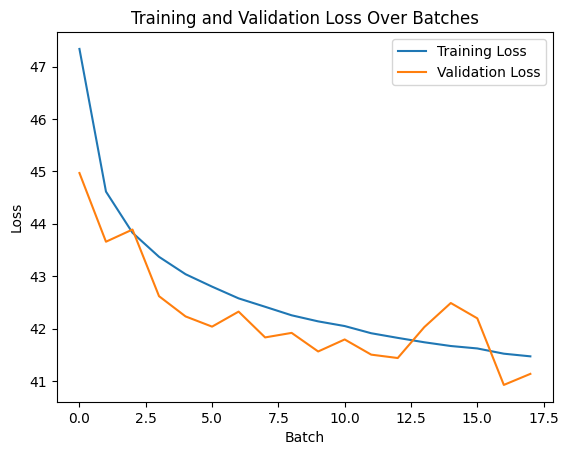

In [ ]:
plot_losses(cnn_train_losses, cnn_val_losses)

In [ ]:
model_path = f'{encoded_data_path}/cnn_cross_attention_774_1d.pt'
torch.save(model.state_dict(), model_path)
count_model_parameters(model)

Total parameters: 13169
Trainable parameters: 13169
Non-trainable parameters: 0


(13169, 13169, 0)

In [ ]:
features, eval = val_dataset[5]
np.log(abs(predict_evaluation(features))) - np.log(abs(eval.item()))

-1.6266486966353293

## Resent model

In [16]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        residual = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += residual  # Add skip connection
        return F.relu(out)


class ChessResCNN(nn.Module):
    def __init__(self):
        super(ChessResCNN, self).__init__()
        # Convolutional layers for board and en passant
        self.res_blocks = nn.Sequential(
            *[ResidualBlock(32) for _ in range(4)]
        )
        self.conv = nn.Sequential(
            nn.Conv2d(12, 16, kernel_size=3, padding=1),  # Input: 12x8x8, Output: 16x8x8
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),  # Output: 32x8x8
            nn.BatchNorm2d(32),
            nn.ReLU(),
            self.res_blocks
        )



        self.metadata_projection = nn.Sequential(
            nn.Linear(6, 32),
            nn.BatchNorm1d(32),
            nn.ReLU()
        )

        self.croos_attention = nn.MultiheadAttention(embed_dim=32, num_heads=8, batch_first=True)

        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32, 1)  # Predict evaluation score
        )
        self.dropout = nn.Dropout(0.2)

    def forward(self, board, metadata):
        batch_size = board.size(0)
        board_features = self.conv(board) # shape Nx32x8x8

        board_projection = board_features.permute(0, 2, 3, 1).reshape(batch_size, 64, 32)
        metadata = self.metadata_projection(metadata) # shape Nx32

        query = metadata.unsqueeze(1) # shape Nx1x32
        key = board_projection # shape Nx64x32
        value = board_projection # shape Nx64x32
        cross_attention_output, _ = self.croos_attention(query, key, value) # shape Nx1x128
        cross_attention_output = cross_attention_output.squeeze(1) # shape Nx128
        combined_features = torch.cat((cross_attention_output, metadata), dim=1) # shape Nx160
        combined_features = self.dropout(combined_features)

        # Pass through fully connected layers
        output = self.fc(combined_features)
        return output


In [ ]:
model = ChessResCNN().to(device)
count_model_parameters(model)
criterion = nn.MSELoss()  # Loss for regression task
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-3)
schedualer = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
epochs = 23
model, res_train_losses, res_val_losses = train_model(model, train_dataloder, val_dataloder, criterion, optimizer, epochs, schedualer, run_name='res_cross_attention')
plot_losses(res_train_losses, res_val_losses)

Total parameters: 87665
Trainable parameters: 87665


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


NameError: name 'train_dataloder' is not defined

In [ ]:
model_path = f'{encoded_data_path}/res_cross_attention_774_1d.pt'
torch.save(model.state_dict(), model_path)
count_model_parameters(model)

In [ ]:
features, eval = val_dataset[5]
np.abs(predict_evaluation(features)) - abs(eval.item())

In [ ]:
count_model_parameters(model)

## Transformer

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        residual = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += residual  # Add skip connection
        return F.relu(out)




class ChessTransformer(nn.Module):
    def __init__(self, emd_dim, nhead, nlayer, dropout):
        super(ChessTransformer, self).__init__()
        self.emd_dim = emd_dim
        # Board encoder
        num_squres = 8 * 8
        # self.squre_embedding = nn.Linear(12, emd_dim)
        self.board_embedding = nn.Sequential(
            nn.Conv2d(12, emd_dim // 2, kernel_size=3, padding=1),  # Input: 12x8x8, Output: 16x8x8
            nn.BatchNorm2d(emd_dim // 2),
            nn.ReLU(),
            nn.Conv2d(emd_dim // 2, emd_dim, kernel_size=3, padding=1),  # Output: 32x8x8
            nn.BatchNorm2d(emd_dim),
            nn.ReLU(),
            *[ResidualBlock(emd_dim) for _ in range(16)],

        )
        self.position_embedding = nn.Parameter(torch.rand(1, num_squres, emd_dim))
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=emd_dim,
                                                        nhead=nhead,
                                                        dropout=dropout,
                                                        batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=nlayer)


        self.metadata_projection = nn.Sequential(
            nn.Linear(6, emd_dim),
            nn.BatchNorm1d(emd_dim),
            nn.ReLU()
        )

        self.croos_attention = nn.MultiheadAttention(embed_dim=emd_dim, num_heads=8, batch_first=True)

        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(emd_dim * 2, emd_dim),
            nn.BatchNorm1d(emd_dim),
            nn.ReLU(),
            nn.Linear(emd_dim, 1)  # Predict evaluation score
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, board, metadata):
        batch_size = board.size(0)
        board_features = self.board_embedding(board) # shape Nx32x8x8
        board_features = board_features.view(batch_size, 8*8, self.emd_dim) # shape Nx8*8(64)xEMB
        board_features = board_features + self.position_embedding
        board_features = self.transformer_encoder(board_features)

        metadata = self.metadata_projection(metadata) # shape NxEMB

        query = metadata.unsqueeze(1) # shape Nx1x32
        cross_attention_output, _ = self.croos_attention(query, board_features, board_features) # shape Nx1x128
        cross_attention_output = cross_attention_output.squeeze(1) # shape NxEMB
        combined_features = torch.cat((cross_attention_output, metadata), dim=1) # shape NxEMB*2
        combined_features = self.dropout(combined_features)

        # Pass through fully connected layers
        output = self.fc(combined_features)
        return output


In [ ]:
# test_dataset = ChessDataset(preprocessed_file=light_encoded_path + '/test.pt')

In [ ]:
2048 * 1.5

3072.0

In [ ]:
BATCH_SIZE = 3072
train_dataloder = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloder = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
# test_dataloder = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
print(f'Batch size: {BATCH_SIZE}')
print(f"Train dataloader size: {len(train_dataloder)}")
print(f"Val dataloader size: {len(val_dataloder)}")

Batch size: 3072
Val dataloader size: 675


#### Normal run

In [ ]:
model = ChessTransformer(emd_dim=64, nhead=8, nlayer=6, dropout=0.3).to(device)
count_model_parameters(model)
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=9e-3, weight_decay=3e-3)
schedualer = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=7, verbose=True)
epochs = 300
model, transformer_train_losses, transformer_val_losses = train_model(model, train_dataloder, val_dataloder, criterion, optimizer, epochs, schedualer, run_name='res16_tr2head4layers_b3072')
plot_losses(transformer_train_losses, transformer_val_losses)

Total parameters: 3205793
Trainable parameters: 3205793


Epoch 1, Batch 1, Loss: 48.52918243408203
Epoch 1, Batch 501, Loss: 61.4871940612793
Epoch 1, Batch 1001, Loss: 67.2904052734375
Epoch 1, Batch 1501, Loss: 68.15376281738281
Epoch 1, Batch 2001, Loss: 68.9084701538086
Epoch 1, Batch 2501, Loss: 64.42695617675781
Model saved with loss: 65.27570375795717
Epoch 1, Training Loss: 65.35493897049516, Validation Loss: 65.27570375795717
Epoch 2, Batch 1, Loss: 52.803131103515625
Epoch 2, Batch 501, Loss: 61.23307418823242
Epoch 2, Batch 1001, Loss: 61.18621063232422
Epoch 2, Batch 1501, Loss: 60.6219482421875
Epoch 2, Batch 2001, Loss: 82.08858489990234
Epoch 2, Batch 2501, Loss: 70.29023742675781
Epoch 2, Training Loss: 65.35451701976635, Validation Loss: 65.27626165884513
Epoch 3, Batch 1, Loss: 70.7977294921875
Epoch 3, Batch 501, Loss: 77.69107818603516
Epoch 3, Batch 1001, Loss: 62.416282653808594
Epoch 3, Batch 1501, Loss: 57.08164978027344
Epoch 3, Batch 2001, Loss: 61.5111198425293
Epoch 3, Batch 2501, Loss: 76.23650360107422
Epoch 3, 

KeyboardInterrupt: 

#### Run with optuna

In [ ]:
# Optuna
study_name = "chess-bot-optimization"
study = optuna.create_study(
    study_name=study_name,
    direction="minimize",
    pruner=optuna.pruners.MedianPruner()
)
study.optimize(
    objective,
    n_trials=50,
    callbacks=[wandb_callback]
)

# Best parameters
print("Best hyperparameters:", study.best_params)
print("Best validation loss:", study.best_value)

# Save the best parameters for future use
best_params = study.best_params
with open("best_hyperparams.json", "w") as f:
    json.dump(best_params, f)

[I 2025-01-16 06:48:55,890] A new study created in memory with name: chess-bot-optimization
<ipython-input-16-7fbf97975f5f>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)
<ipython-input-16-7fbf97975f5f>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1, Batch 1, Loss: 61.23160934448242
Epoch 1, Batch 501, Loss: 65.76482391357422
Epoch 1, Batch 1001, Loss: 52.73193359375
Epoch 1, Batch 1501, Loss: 65.86100769042969
Epoch 1, Batch 2001, Loss: 60.311439514160156
Epoch 1, Batch 2501, Loss: 67.29354858398438
Model saved with loss: 65.27579576280382
Epoch 1, Training Loss: 65.35640543902362, Validation Loss: 65.27579576280382
Epoch 2, Batch 1, Loss: 67.56344604492188
Epoch 2, Batch 501, Loss: 72.57496643066406
Epoch 2, Batch 1001, Loss: 69.86270141601562
Epoch 2, Batch 1501, Loss: 63.47317123413086
Epoch 2, Batch 2001, Loss: 58.24393844604492
Epoch 2, Batch 2501, Loss: 66.09400939941406
Epoch 2, Training Loss: 65.35191505149558, Validation Loss: 65.276435196488
Epoch 3, Batch 1, Loss: 71.21018981933594
Epoch 3, Batch 501, Loss: 58.36155319213867
Epoch 3, Batch 1001, Loss: 56.89707946777344
Epoch 3, Batch 1501, Loss: 70.39955139160156
Epoch 3, Batch 2001, Loss: 56.93246078491211
Epoch 3, Batch 2501, Loss: 67.03019714355469
Epoch 3, 

batch,▁▂▅▇█▂▄▇█▁▅▇█▁▂▇▁▂▄▇▁▂▄█▂▇█▁▂▄▇█▂▅▇▁▂▄▅█
batch loss,▄▄▃▅▅▅▄▃▄▅▃▅▄▄▅▆▅▄▄▄▇▄▁▂▄▃▃▃▅▅▃▄▅▂▂▄█▇▆▃
epoch,▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇██
train loss,█▄▃▄▁▄▁▅▃▃
val loss,▁▂█▃▂▃▂▅▄▄
batch,2501
batch loss,60.3379
epoch,10
train loss,65.35013
val loss,65.27893


[I 2025-01-16 08:56:16,484] Trial 0 finished with value: 65.27579576280382 and parameters: {'emd_dim': 32, 'nhead': 4, 'nlayer': 5, 'dropout': 0.30000000000000004, 'lr': 0.0032264056025385034, 'weight_decay': 0.0005096183028847973, 'patience': 9}. Best is trial 0 with value: 65.27579576280382.


<ipython-input-16-7fbf97975f5f>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)
<ipython-input-16-7fbf97975f5f>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)


Epoch 1, Batch 1, Loss: 63.66099166870117
Epoch 1, Batch 501, Loss: 55.75922775268555
Epoch 1, Batch 1001, Loss: 53.73973846435547
Epoch 1, Batch 1501, Loss: 44.387413024902344
Epoch 1, Batch 2001, Loss: 39.17041015625
Epoch 1, Batch 2501, Loss: 56.1229362487793
Model saved with loss: 44.080013057567456
Epoch 1, Training Loss: 49.86015061625728, Validation Loss: 44.080013057567456
Epoch 2, Batch 1, Loss: 45.478172302246094
Epoch 2, Batch 501, Loss: 44.50468444824219
Epoch 2, Batch 1001, Loss: 43.552162170410156
Epoch 2, Batch 1501, Loss: 43.757904052734375
Epoch 2, Batch 2001, Loss: 36.90703582763672
Epoch 2, Batch 2501, Loss: 41.99976348876953
Model saved with loss: 43.23158357408312
Epoch 2, Training Loss: 42.92667942259047, Validation Loss: 43.23158357408312
Epoch 3, Batch 1, Loss: 41.005619049072266
Epoch 3, Batch 501, Loss: 47.123046875
Epoch 3, Batch 1001, Loss: 47.8671875
Epoch 3, Batch 1501, Loss: 35.859169006347656
Epoch 3, Batch 2001, Loss: 43.82025146484375
Epoch 3, Batch 25

batch,▁▂▄▅▇▁▄█▁▂▅▇█▁▅▁▄▅▇█▂▄▅▇█▂▄▅▇▂▅█▄▅▇▁▂▄▅█
batch loss,█▆▄▄▇▃▄▅▅▃▅▄▄▄▃▁▃▄▃▃▃▃▂▁▃▁▁▂▂▂▁▂▁▂▃▁▂▄▂▃
dropout,▁
emd_dim,▁
epoch,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇███
lr,▁
nhead,▁
nlayer,▁
patience,▁
train loss,█▆▅▄▃▃▂▂▁▁
val loss,█▇▅▄▂▁▁▆▄▃


[I 2025-01-16 10:36:01,424] Trial 1 finished with value: 38.41972334685149 and parameters: {'emd_dim': 64, 'nhead': 4, 'nlayer': 2, 'dropout': 0.1, 'lr': 7.806394739758474e-05, 'weight_decay': 0.0005398472888596674, 'patience': 10}. Best is trial 1 with value: 38.41972334685149.


Epoch 1, Batch 1, Loss: 70.54393005371094
Epoch 1, Batch 501, Loss: 71.86837005615234
Epoch 1, Batch 1001, Loss: 69.68022155761719
Epoch 1, Batch 1501, Loss: 78.32926940917969
Epoch 1, Batch 2001, Loss: 69.7746353149414
Epoch 1, Batch 2501, Loss: 58.181087493896484
Model saved with loss: 65.27759554262515
Epoch 1, Training Loss: 65.35979077939633, Validation Loss: 65.27759554262515
Epoch 2, Batch 1, Loss: 63.477294921875
Epoch 2, Batch 501, Loss: 61.66253662109375
Epoch 2, Batch 1001, Loss: 76.70235443115234
Epoch 2, Batch 1501, Loss: 53.50636291503906
Epoch 2, Batch 2001, Loss: 69.69477844238281
Epoch 2, Batch 2501, Loss: 53.462703704833984
Epoch 2, Training Loss: 65.3537064714785, Validation Loss: 65.27937518649631
Epoch 3, Batch 1, Loss: 63.837921142578125
Epoch 3, Batch 501, Loss: 66.83269500732422
Epoch 3, Batch 1001, Loss: 79.30732727050781
Epoch 3, Batch 1501, Loss: 70.34858703613281
Epoch 3, Batch 2001, Loss: 64.97990417480469
Epoch 3, Batch 2501, Loss: 70.92357635498047
Epoch 

batch,▁▂▄▇▅▁▂▄▅▇▁▂▄▅▇▁▂▅▇█▂▄▅▇█▄▇█▁▄▇█▁▂▄█▁▂▄▇
batch loss,▅▅▆▃▄▂▅▄▄▆▄▅▆▃▅▁▃▆▅▆▃▃▆▆▂▂▄▃▆▄▅▄▄▅▃▄▆█▄▄
dropout,▁
emd_dim,▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇███
lr,▁
nhead,▁
nlayer,▁
patience,▁
train loss,█▄▃▂▂▂▃▁▁▂
val loss,▁▂█▄▂▂▂▂▂▂


[I 2025-01-16 12:56:31,474] Trial 2 finished with value: 65.27759554262515 and parameters: {'emd_dim': 32, 'nhead': 2, 'nlayer': 6, 'dropout': 0.5, 'lr': 0.0066937358896463715, 'weight_decay': 0.0004545284426860242, 'patience': 4}. Best is trial 1 with value: 38.41972334685149.


Epoch 1, Batch 1, Loss: 60.9716796875
Epoch 1, Batch 501, Loss: 62.11461639404297
Epoch 1, Batch 1001, Loss: 61.72838592529297
Epoch 1, Batch 1501, Loss: 72.73117065429688
Epoch 1, Batch 2001, Loss: 60.49497985839844
Epoch 1, Batch 2501, Loss: 65.99609375
Model saved with loss: 58.13401852643048
Epoch 1, Training Loss: 61.91618982668276, Validation Loss: 58.13401852643048
Epoch 2, Batch 1, Loss: 64.75402069091797
Epoch 2, Batch 501, Loss: 55.051666259765625
Epoch 2, Batch 1001, Loss: 52.87263107299805
Epoch 2, Batch 1501, Loss: 65.46510314941406
Epoch 2, Batch 2001, Loss: 47.73560333251953
Epoch 2, Batch 2501, Loss: 45.91740417480469
Model saved with loss: 55.08035355179398
Epoch 2, Training Loss: 56.55980428201181, Validation Loss: 55.08035355179398
Epoch 3, Batch 1, Loss: 59.690086364746094
Epoch 3, Batch 501, Loss: 49.65956115722656
Epoch 3, Batch 1001, Loss: 53.88560104370117
Epoch 3, Batch 1501, Loss: 48.180389404296875
Epoch 3, Batch 2001, Loss: 48.70948791503906
Epoch 3, Batch 2

batch,▁▂▄▅▇▁▂▅▇█▄▇█▁▂▅▇▁▂▅█▂▅▇█▂▄▇█▁▄▅█▁▂▅▇▁▂█
batch loss,▆▆█▅▇▄▆▃▂▅▃▃▃▅▃▃▅▃▅▂▄▃▄▁▃▁▂▃▅▄▂▃▂▂▃▃▃▅▂▃
dropout,▁
emd_dim,▁
epoch,▁▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇███
lr,▁
nhead,▁
nlayer,▁
patience,▁
train loss,█▆▄▃▃▂▂▂▁▁
val loss,█▆▄▃▃▂▂▁▁▁


[I 2025-01-16 15:04:00,000] Trial 3 finished with value: 48.1742945183648 and parameters: {'emd_dim': 32, 'nhead': 4, 'nlayer': 5, 'dropout': 0.30000000000000004, 'lr': 1.3196731563673313e-05, 'weight_decay': 1.3792487419658733e-05, 'patience': 3}. Best is trial 1 with value: 38.41972334685149.


Epoch 1, Batch 1, Loss: 72.10045623779297
Epoch 1, Batch 501, Loss: 77.63579559326172
Epoch 1, Batch 1001, Loss: 58.374412536621094
Epoch 1, Batch 1501, Loss: 51.40257263183594
Epoch 1, Batch 2001, Loss: 45.891082763671875
Epoch 1, Batch 2501, Loss: 52.36989974975586
Model saved with loss: 52.46357231422707
Epoch 1, Training Loss: 57.51812304885299, Validation Loss: 52.46357231422707
Epoch 2, Batch 1, Loss: 51.1471061706543
Epoch 2, Batch 501, Loss: 49.0098991394043
Epoch 2, Batch 1001, Loss: 59.705257415771484
Epoch 2, Batch 1501, Loss: 49.22124481201172
Epoch 2, Batch 2001, Loss: 52.717002868652344
Epoch 2, Batch 2501, Loss: 45.70025634765625
Model saved with loss: 49.85465020638925
Epoch 2, Training Loss: 50.8635929941248, Validation Loss: 49.85465020638925
Epoch 3, Batch 1, Loss: 50.4426383972168
Epoch 3, Batch 501, Loss: 51.942466735839844
Epoch 3, Batch 1001, Loss: 40.45685958862305
Epoch 3, Batch 1501, Loss: 51.653175354003906
Epoch 3, Batch 2001, Loss: 46.606964111328125
Epoch 

[W 2025-01-16 16:46:23,334] Trial 4 failed with parameters: {'emd_dim': 32, 'nhead': 8, 'nlayer': 4, 'dropout': 0.2, 'lr': 3.325381773704812e-05, 'weight_decay': 0.0002285676069645684, 'patience': 5} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "<ipython-input-16-7fbf97975f5f>", line 27, in objective
    model, train_losses, val_losses = train_model(
                                      ^^^^^^^^^^^^
  File "<ipython-input-14-44eed943c866>", line 26, in train_model
    loss.backward()
  File "/usr/local/lib/python3.11/dist-packages/torch/_tensor.py", line 581, in backward
    torch.autograd.backward(
  File "/usr/local/lib/python3.11/dist-packages/torch/autograd/__init__.py", line 347, in backward
    _engine_run_backward(
  File "/usr/local/lib/python3.11/dist-packages/t

KeyboardInterrupt: 

#### Normal with optuna best params

In [ ]:
params = study.best_params
params

{'emd_dim': 64,
 'nhead': 4,
 'nlayer': 2,
 'dropout': 0.1,
 'lr': 7.806394739758474e-05,
 'weight_decay': 0.0005398472888596674,
 'patience': 10}

In [ ]:
study.best_value

38.41972334685149

In [ ]:
{'emd_dim': 64,
 'nhead': 4,
 'nlayer': 2,
 'dropout': 0.1,
 'lr': 7.806394739758474e-05,
 'weight_decay': 0.0005398472888596674,
 'patience': 10}

In [ ]:
model = ChessTransformer(emd_dim=params['emd_dim'],
                         nhead=params['nhead'],
                         nlayer=params['nlayer'],
                         dropout=params['dropout']).to(device)
count_model_parameters(model)
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(),
                        lr=params['lr'],
                        weight_decay=params['weight_decay'])
schedualer = ReduceLROnPlateau(optimizer,
                               mode='min',
                               factor=0.1,
                               patience=params['patience'],
                               verbose=True)
epochs = 300
model, transformer_train_losses, transformer_val_losses = train_model(model, train_dataloder, val_dataloder, criterion, optimizer, epochs, schedualer, run_name='res16_tr2head4layers_b3072')
plot_losses(transformer_train_losses, transformer_val_losses)

Total parameters: 2081185
Trainable parameters: 2081185


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1, Batch 1, Loss: 64.63636016845703
Epoch 1, Batch 501, Loss: 56.63813400268555
Epoch 1, Batch 1001, Loss: 42.15333557128906
Epoch 1, Batch 1501, Loss: 46.724021911621094
Epoch 1, Batch 2001, Loss: 54.9631462097168
Epoch 1, Batch 2501, Loss: 59.18070602416992
Model saved with loss: 46.80566114355017
Epoch 1, Training Loss: 50.26625074810452, Validation Loss: 46.80566114355017
Epoch 2, Batch 1, Loss: 38.39841842651367
Epoch 2, Batch 501, Loss: 38.766143798828125
Epoch 2, Batch 1001, Loss: 51.93308639526367
Epoch 2, Batch 1501, Loss: 41.825897216796875
Epoch 2, Batch 2001, Loss: 37.842567443847656
Epoch 2, Batch 2501, Loss: 39.60890579223633
Model saved with loss: 42.25617374278881
Epoch 2, Training Loss: 43.09592334040889, Validation Loss: 42.25617374278881
Epoch 3, Batch 1, Loss: 45.40521240234375
Epoch 3, Batch 501, Loss: 40.00227355957031
Epoch 3, Batch 1001, Loss: 36.055572509765625
Epoch 3, Batch 1501, Loss: 41.49726867675781
Epoch 3, Batch 2001, Loss: 37.512325286865234
Epoc

KeyboardInterrupt: 

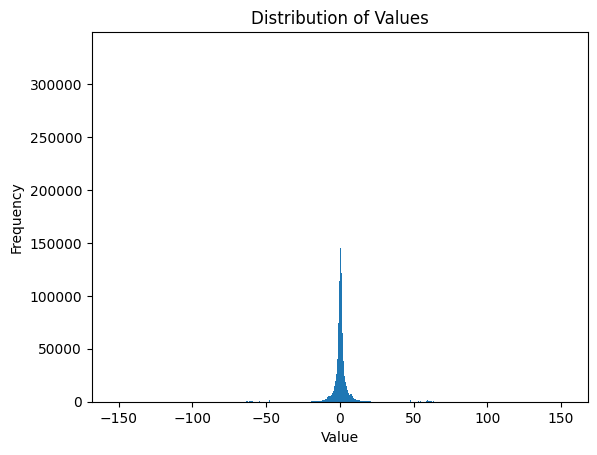

14247

In [ ]:
labels = val_dataset.labels.cpu().numpy().flatten()
plt.hist(labels, bins=1000)  # Flatten the tensor for histogram
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of Values')
plt.show()
(labels > 50).sum()

# Anlyze models

In [ ]:
BATCH_SIZE = 3072
val_dataloder = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataloder = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
def get_model_preds(model, dataloader, device):
    model = model.to(device)
    model.eval()
    preds = []
    with torch.no_grad():
        for batch in tqdm(dataloader):
            features, target = batch
            features = features.to(device)
            target = target.to(device)
            board, metadata = split_tensor(features)
            output = model(board, metadata)
            preds.append(output.cpu().numpy().flatten())
    return np.concatenate(preds)

In [ ]:
res_model = load_checkpoint(ChessResCNN(), f'{encoded_data_path}/res_cross_attention_best_model.pth').to(device)

<ipython-input-22-d34ddf0421bb>:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Model loaded from drive/MyDrive/data/chess_bot_batches/res_cross_attention_best_model.pth


In [ ]:
model_preds_test = get_model_preds(res_model, test_dataloder, device)
labels_test = test_dataset.labels.cpu().numpy().flatten()

100%|██████████| 844/844 [00:27<00:00, 30.15it/s]


In [ ]:
# MSE on test
((model_preds_test - labels_test) ** 2).mean()

36.830776

In [ ]:
model_preds = get_model_preds(res_model, val_dataloder, device)
labels = val_dataset.labels.cpu().numpy().flatten()
diff = model_preds - labels
diff_abs = np.abs(diff)
df = pd.DataFrame({'model_preds': model_preds, 'labels': labels, 'diff': diff, 'diff_abs': diff_abs})
df.to_csv(f'{encoded_data_path}/res_cross_attention_preds.csv', index=False)
df[['diff', 'diff_abs']].describe()

100%|██████████| 675/675 [00:24<00:00, 27.23it/s]


,model_preds,labels,diff,diff_abs
count,2.073286e+06,2.073286e+06,2.073286e+06,2.073286e+06
mean,3.430948e-01,4.498735e-01,-1.067789e-01,2.416957e+00
std,5.563135e+00,8.064794e+00,6.061648e+00,5.563951e+00
min,-8.318629e+01,-1.529100e+02,-1.224386e+02,1.251698e-06
25%,-6.215833e-01,-7.300000e-01,-1.049816e+00,4.064892e-01
50%,2.708112e-01,1.500000e-01,-6.689107e-02,9.712698e-01
75%,1.209611e+00,1.410000e+00,8.911281e-01,2.206669e+00
max,8.953153e+01,1.529100e+02,1.353704e+02,1.353704e+02


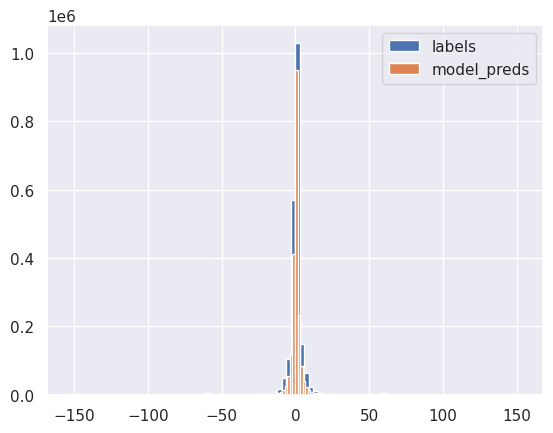

In [ ]:
df['labels'].hist(bins=100, label='labels')
df['model_preds'].hist(bins=100, label='model_preds')
plt.legend()

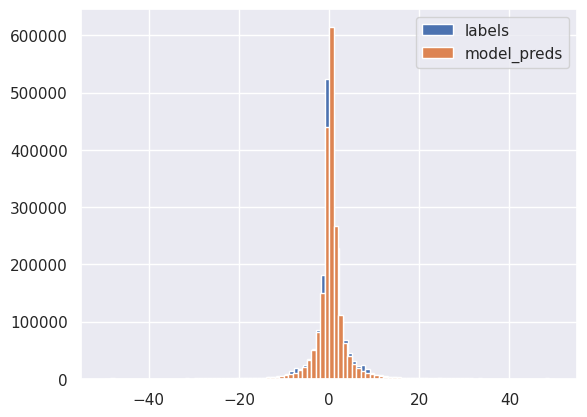

In [ ]:
# Hist without outilners
df.loc[df['labels'].abs() < 50,'labels'].hist(bins=100, label='labels')
df.loc[df['model_preds'].abs() < 50, 'model_preds'].hist(bins=100, label='model_preds')
plt.legend()

<Axes: >

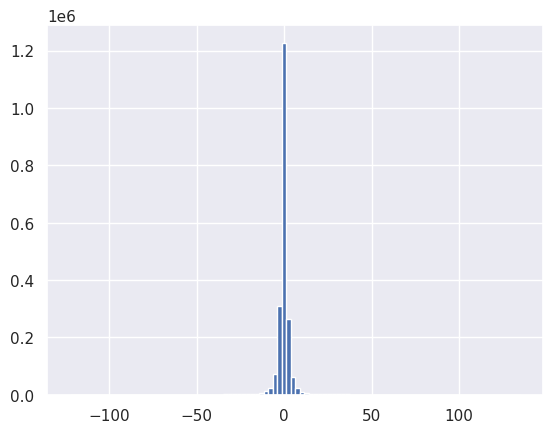

In [ ]:
df['diff'].hist(bins=100)

### Check mate evalutaion

In [ ]:
mates_mask = df['labels'].abs() > 50
mates_df = df[mates_mask]

In [ ]:
mates_df.head()

,model_preds,labels,diff,diff_abs
229,16.474977,63.279999,-46.805023,46.805023
283,-10.679924,-59.380001,48.700077,48.700077
449,18.577524,63.279999,-44.702477,44.702477
532,-32.417534,-53.840000,21.422466,21.422466
585,-32.209579,-59.560001,27.350422,27.350422


Text(0.5, 1.0, 'Distribution of Differences Between Mates and Non-Mates')

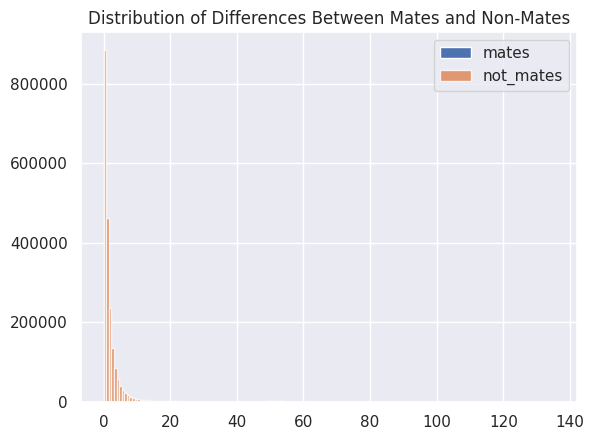

In [ ]:
df.loc[mates_mask, 'diff_abs'].hist(bins=100, label='mates')
df.loc[~mates_mask, 'diff_abs'].hist(bins=100, label='not_mates', alpha=0.8)
plt.legend()
plt.title('Distribution of Differences Between Mates and Non-Mates')

Text(0.5, 1.0, 'Distribution of Differences Between Mates and Non-Mates Filtered Outliners')

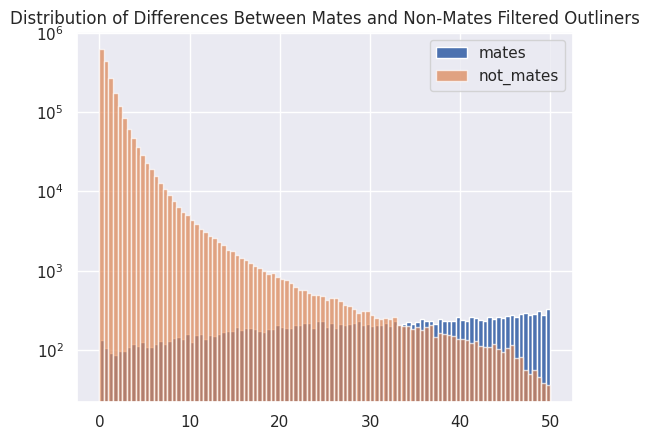

In [ ]:
# Filter outliners
mask = df['diff_abs'] < 50
df.loc[mates_mask & mask, 'diff_abs'].hist(bins=100, label='mates', log=True)
df.loc[(~mates_mask) & mask, 'diff_abs'].hist(bins=100, label='not_mates', alpha=0.7, log=True)
plt.legend()
plt.title('Distribution of Differences Between Mates and Non-Mates Filtered Outliners')

## Conculation
The model predicts well for non mates FAN, buthas struggle to predict when there an option for mate

# Is mate Model

Since the evaluation model strugle with mates we will split the problem to 3 models:
1. Is mate?
2. evaluation for mates only
3. evaluation for no mates only

In [ ]:
print('Loading data...')
train_dataset = ChessDataset(preprocessed_file=light_encoded_path + '/train.pt')
val_dataset = ChessDataset(preprocessed_file=light_encoded_path + '/val.pt')
# test_dataset = ChessDataset(preprocessed_file=light_encoded_path + '/test.pt')

Loading data...
Loading preprocessed dataset from drive/MyDrive/data/chess_bot_batches/light_774_1d/train.pt...


<ipython-input-7-40abdb63fe2b>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(preprocessed_file)


Loading preprocessed dataset from drive/MyDrive/data/chess_bot_batches/light_774_1d/val.pt...


In [ ]:
BATCH_SIZE = 2048
train_dataloder = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloder = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
# test_dataloder = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
print(f'Batch size: {BATCH_SIZE}')
print(f"Train dataloader size: {len(train_dataloder)}")
print(f"Val dataloader size: {len(val_dataloder)}")

Batch size: 2048
Train dataloader size: 4050
Val dataloader size: 1013


## Is-Mate Mdoel

#### Model Class Defenition

In [17]:
class ResidualBlockIsMates(nn.Module):
    def __init__(self, channels, dropout=0.0):
        super(ResidualBlockIsMates, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)
        self.dropout = nn.Dropout2d(dropout)

    def forward(self, x):
        residual = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.dropout(out)
        out = self.bn2(self.conv2(out))
        out += residual  # Add skip connection
        return F.relu(out)


class IsMateRes(nn.Module):
    def __init__(self):
        super(IsMateRes, self).__init__()
        # Convolutional layers for board and en passant
        self.res_blocks = nn.Sequential(
            *[ResidualBlockIsMates(16, 0.2) for _ in range(4)]
        )
        self.conv = nn.Sequential(
            nn.Conv2d(12, 16, kernel_size=3, padding=1),  # Input: 12x8x8, Output: 16x8x8
            nn.BatchNorm2d(16),
            nn.ReLU(),
            self.res_blocks
        )



        self.metadata_projection = nn.Sequential(
            nn.Linear(6, 16),
            nn.BatchNorm1d(16),
            nn.ReLU()
        )

        self.croos_attention = nn.MultiheadAttention(embed_dim=16, num_heads=8, batch_first=True)

        # Fully connected layers
        self.fc = nn.Linear(32, 1)
        self.dropout = nn.Dropout(0.2)

    def forward(self, board, metadata):
        batch_size = board.size(0)
        board_features = self.conv(board) # shape Nx16x8x8

        board_projection = board_features.permute(0, 2, 3, 1).reshape(batch_size, 64, 16)
        metadata = self.metadata_projection(metadata) # shape Nx16

        query = metadata.unsqueeze(1) # shape Nx1x16
        key = board_projection # shape Nx64x16
        value = board_projection # shape Nx64x16
        cross_attention_output, _ = self.croos_attention(query, key, value) # shape Nx1x32
        cross_attention_output = cross_attention_output.squeeze(1) # shape Nx32
        combined_features = torch.cat((cross_attention_output, metadata), dim=1) # shape Nx48
        combined_features = self.dropout(combined_features)

        # Pass through fully connected layers
        output = self.fc(combined_features)
        return output


#### Training the model

In [ ]:
def evaluate_model(model, criterion, dataloader, device, label_threshold=None):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in dataloader:
            features, target = batch
            if label_threshold is not None:
                  target = torch.where(target > label_threshold, 1, 0).float()
            features = features.to(device)
            target = target.to(device)
            board, metadata = split_tensor(features)
            output = model(board, metadata)
            loss = criterion(output, target.view(-1, 1))
            total_loss += loss.item()
            if label_threshold is not None:
                predicted = (output > label_threshold).float()
                correct += (predicted == target).sum().item()
            total += target.size(0)
    if label_threshold is not None:
        accuracy = correct / total
        return total_loss / len(dataloader), accuracy
    return total_loss / len(dataloader)

def train_model(model,
                train_loader,
                val_loader,
                criterion,
                optimizer,
                num_epochs,
                schedualer,
                run_name=None,
                label_threshold=None):
    wandb.init(project=project_name, name=run_name)
    wandb.watch(model, criterion, log="all", log_freq=100)

    best_loss = float('inf')
    # Define a model path for saving the best checkpoint.
    # Use run_name to create a unique filename if provided.
    model_path = encoded_data_path + f"/{run_name}_best_model.pth" if run_name else "/best_model.pth"
    try:
      train_losses = []
      val_losses = []
      train_accuracies = []
      val_accuracies = []
      for epoch in range(num_epochs):
          model.train()
          total_loss = 0.0
          currect = 0
          total = 0
          for i, batch in enumerate(train_loader):
              features, target = batch
              if label_threshold is not None:
                  target = torch.where(target > label_threshold, 1, 0).float()
              features = features.to(device)
              target = target.to(device)
              board, metadata = split_tensor(features)

              output = model(board, metadata)
              loss = criterion(output, target.view(-1, 1))
              total_loss += loss.item()
              if label_threshold is not None:
                  predicted = (output > label_threshold).float()
                  currect += (predicted == target).sum().item()
              total += target.size(0)

              optimizer.zero_grad()
              loss.backward()
              # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
              optimizer.step()
              if i % 500 == 0:
                  print(f"Epoch {epoch + 1}, Batch {i + 1}, Loss: {loss.item()}")
                  wandb.log({"batch loss": loss.item(),
                            'epoch': epoch+1,
                            'batch': i + 1})


          train_loss = total_loss / len(train_loader)
          train_losses.append(train_loss)
          if label_threshold is not None:
              train_accuracy = currect / total
              train_accuracies.append(train_accuracy)
              val_loss, val_accuracy = evaluate_model(model, criterion, val_loader, device, label_threshold=label_threshold)
              val_losses.append(val_loss)
              val_accuracies.append(val_accuracy)
          else:
            val_loss = evaluate_model(model, criterion, val_loader, device)
            val_losses.append(val_loss)

          schedualer.step(val_loss)
          # Save checkpoint if validation loss improved
          best_loss = save_checkpoint(model, model_path, val_loss, best_loss)

          if label_threshold is not None:
              print(f"Epoch {epoch + 1}, Training Loss: {train_loss}, Training Accuracy: {train_accuracy}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")
              wandb.log({'train accuracy': train_accuracy,
                         'val accuracy': val_accuracy,
                         "train loss": train_loss,
                         "val loss": val_loss,
                         'epoch': epoch+1})
          else:
            print(f"Epoch {epoch + 1}, Training Loss: {train_loss}, Validation Loss: {val_loss}")
            wandb.log({"train loss": train_loss,
                       "val loss": val_loss,
                       'epoch': epoch+1})
      wandb.finish()
    except Exception as e:
      print(f"An error occurred: {e}")
      wandb.log({"error": str(e)})
      wandb.finish()
      raise e
    return model, train_losses, val_losses

In [ ]:
BATCH_SIZE = 3072
train_dataloder = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloder = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
# test_dataloder = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
print(f'Batch size: {BATCH_SIZE}')
print(f"Train dataloader size: {len(train_dataloder)}")
print(f"Val dataloader size: {len(val_dataloder)}")

Batch size: 3072
Train dataloader size: 2700
Val dataloader size: 675


In [ ]:
train_labels_binary = torch.where(train_dataset.labels > 50, 1, 0).float()
num_positives = (train_labels_binary == 1).sum().item()
num_negatives = (train_labels_binary == 0).sum().item()
pos_weight = torch.tensor(num_negatives / (num_positives + 1e-6), dtype=torch.float32)
print(f"Number of positive samples: {num_positives}")
print(f"Number of negative samples: {num_negatives}")
print(f"Positive weight: {pos_weight}")

Number of positive samples: 57000
Number of negative samples: 8236142
Positive weight: 144.49371337890625


In [ ]:
model = IsMateRes().to(device)
count_model_parameters(model)
criterion = nn.BCEWithLogitsLoss(reduction="mean", pos_weight=pos_weight)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-3)
schedualer = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
epochs = 7
outputs = train_model(model,
                      train_dataloder,
                      val_dataloder,
                      criterion,
                      optimizer,
                      epochs,
                      schedualer,
                      run_name='is_mate',
                      label_threshold=50)
# plot_losses(is_mate_train_losses, is_mate_val_losses)

Total parameters: 21857
Trainable parameters: 21857


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1, Batch 1, Loss: 1.321530818939209
Epoch 1, Batch 501, Loss: 0.5297541618347168
Epoch 1, Batch 1001, Loss: 0.5903561115264893
Epoch 1, Batch 1501, Loss: 0.7281818389892578
Epoch 1, Batch 2001, Loss: 0.5055427551269531
Epoch 1, Batch 2501, Loss: 0.43470391631126404
Model saved with loss: 0.5420179423137947
Epoch 1, Training Loss: 0.6323195283501236, Training Accuracy: 3050.6127933176595, Validation Loss: 0.5420179423137947, Validation Accuracy: 3050.4754655170586
Epoch 2, Batch 1, Loss: 0.41601142287254333
Epoch 2, Batch 501, Loss: 0.5290576815605164
Epoch 2, Batch 1001, Loss: 0.4018399119377136
Epoch 2, Batch 1501, Loss: 0.3713078200817108
Epoch 2, Batch 2001, Loss: 0.43433791399002075
Epoch 2, Batch 2501, Loss: 0.3886203467845917
Model saved with loss: 0.5089291135028556
Epoch 2, Training Loss: 0.5189189286474828, Training Accuracy: 3050.612186551249, Validation Loss: 0.5089291135028556, Validation Accuracy: 3050.4754655170586
Epoch 3, Batch 1, Loss: 0.40340182185173035
Epoch 3

batch,▁▂▄▅▇█▁▂▄▅▇█▁▂▄▅▇█▁▂▅▇█▁▂▄▅▇█▁▂▄▅▇█▁▂▄▅█
batch loss,█▂▃▄▂▂▂▂▁▁▂▁▁▁▂▁▂▂▁▂▃▂▁▁▂▁▃▂▁▁▃▃▂▁▁▂▂▂▃▃
epoch,▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█████
train accuracy,▅▂▁▂▇█▇
train loss,█▄▃▂▂▁▁
val accuracy,▁▁▁▁▁▁▁
val loss,█▆▃▂▂▁▂
batch,2501
batch loss,0.60479
epoch,7
train accuracy,3050.6131


In [ ]:
model, train_losses, val_losses = outputs

In [ ]:
def compute_accuracy(model, dataloader, device, label_threshold=50):
    model.eval()
    correct = 0
    total_samples = 0

    with torch.no_grad():
        for features, target in tqdm(dataloader):
            if label_threshold is not None:
                target = torch.where(target > label_threshold, 1, 0).float()  # Binarize labels

            features = features.to(device)
            target = target.to(device)
            board, metadata = split_tensor(features)

            logits = model(board, metadata)  # Get raw model outputs (logits)
            predictions = (torch.sigmoid(logits) > 0.5).float()  # Convert logits to binary predictions

            correct += (predictions.view(-1) == target.view(-1)).sum().item()
            total_samples += target.size(0)

    accuracy = correct / total_samples
    return accuracy

In [ ]:
compute_accuracy(model, val_dataloder, device, label_threshold=50)

100%|██████████| 675/675 [00:29<00:00, 23.01it/s]


0.8355320973565634

In [ ]:
compute_accuracy(model, train_dataloder, device, label_threshold=50)

100%|██████████| 2700/2700 [01:35<00:00, 28.28it/s]


0.8355462863170557

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def compute_confusion_matrix(model, dataloader, device, label_threshold):
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for features, target in dataloader:
            if label_threshold is not None:
                target = torch.where(target > label_threshold, 1, 0).float()

            features = features.to(device)
            target = target.to(device)
            board, metadata = split_tensor(features)

            logits = model(board, metadata)
            predictions = (torch.sigmoid(logits) > 0.5).float()  # Convert logits to binary predictions

            all_preds.extend(predictions.cpu().numpy().flatten())
            all_targets.extend(target.cpu().numpy().flatten())

    # Compute confusion matrix
    cm = confusion_matrix(all_targets, all_preds)

    # Normalize by row (actual class) sum
    cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)

    return cm, cm_normalized

def plot_confusion_matrix(cm_normalized):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Normalized Confusion Matrix")
    plt.show()

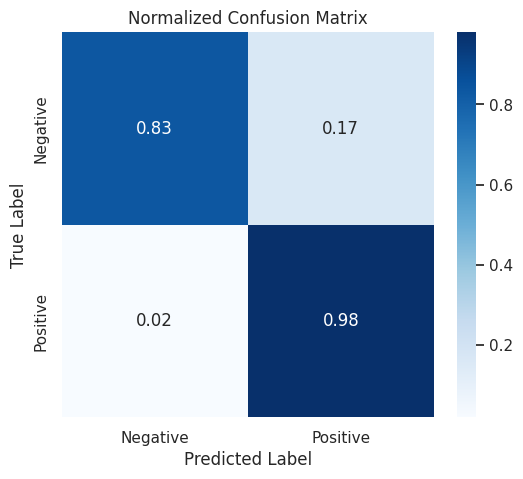

In [ ]:
cm, cm_normalized = compute_confusion_matrix(model, val_dataloder, device, label_threshold=50)
plot_confusion_matrix(cm_normalized)

In [ ]:
wandb.init()
# wandb.unwatch(model)

## evaluation for mates only

In [ ]:
def subset_mates(dataset):
    is_mate = dataset.labels.abs() > 50
    is_mate_mask = torch.tensor(is_mate)
    is_mate_dataset = Subset(dataset, is_mate_mask)
    return is_mate_dataset
train_is_mate_dataset = subset_mates(train_dataset)
val_is_mate_dataset = subset_mates(val_dataset)

Total parameters: 87665
Trainable parameters: 87665
Epoch 1, Batch 1, Loss: 68.03384399414062
Epoch 1, Batch 501, Loss: 55.44236755371094
Epoch 1, Batch 1001, Loss: 49.99418258666992
Epoch 1, Batch 1501, Loss: 63.94085693359375
Epoch 1, Batch 2001, Loss: 43.15082931518555
Epoch 1, Batch 2501, Loss: 55.351707458496094
Model saved with loss: 46.488864452220774
Epoch 1, Training Loss: 51.7232373103389, Validation Loss: 46.488864452220774
Epoch 2, Batch 1, Loss: 50.99630355834961
Epoch 2, Batch 501, Loss: 49.73774337768555
Epoch 2, Batch 1001, Loss: 45.34832763671875
Epoch 2, Batch 1501, Loss: 35.82709884643555
Epoch 2, Batch 2001, Loss: 43.14257049560547
Epoch 2, Batch 2501, Loss: 45.83122253417969
Model saved with loss: 43.673096214577
Epoch 2, Training Loss: 45.212675690121124, Validation Loss: 43.673096214577
Epoch 3, Batch 1, Loss: 45.48252868652344
Epoch 3, Batch 501, Loss: 47.66436004638672
Epoch 3, Batch 1001, Loss: 49.70513153076172
Epoch 3, Batch 1501, Loss: 33.55984115600586
Epo

batch,▁▁▁█▂▇▄▇▄▇█▂▅▇▂▄▇▂▄▇▇▁▄▇█▂▅▂▄▇▅█▁▄▅▅▇▂▄█
batch loss,▅▄▄▄▃█▆▂▄▅▃▃▄▃▅▅▂▃▃▅▁▃▂▂▄▂▂▄▄▅▂▂▁▂▂▂▂▂▂▂
epoch,▁▁▂▂▂▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▇▇▇▇███
train loss,█▅▄█▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁
val loss,█▆▄▇▅▄▄▃▃▃▂▂▂▁▄▁▃▁▁▂▁▁▂▁▁▁
batch,2501
batch loss,37.34498
epoch,23
train loss,35.78888
val loss,38.88897


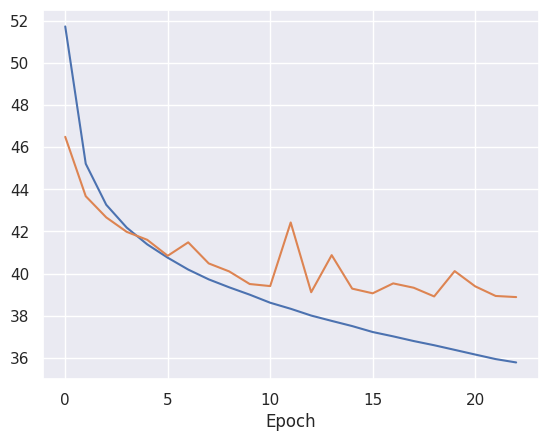

In [ ]:
model = ChessResCNN().to(device)
count_model_parameters(model)
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-3)
schedualer = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
epochs = 23
model, train_losses, val_losses = train_model(model,
                      train_dataloder,
                      val_dataloder,
                      criterion,
                      optimizer,
                      epochs,
                      schedualer,
                      run_name='mates_only_evaluation')
plot_losses(train_losses, val_losses)

## Only No-Mates

In [ ]:
def subset_no_mates(dataset):
    no_mate = dataset.labels.abs() <= 50
    no_mate_mask = torch.tensor(no_mate)
    no_mate_dataset = Subset(dataset, no_mate_mask)
    return no_mate_dataset
train_no_mate_dataset = subset_no_mates(train_dataset)
val_no_mate_dataset = subset_no_mates(val_dataset)

<ipython-input-67-b0269d174e7b>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  no_mate_mask = torch.tensor(no_mate)


Total parameters: 87665
Trainable parameters: 87665


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1, Batch 1, Loss: 55.517051696777344
Epoch 1, Batch 501, Loss: 51.1351318359375
Epoch 1, Batch 1001, Loss: 59.802146911621094
Epoch 1, Batch 1501, Loss: 47.890586853027344
Epoch 1, Batch 2001, Loss: 50.050750732421875
Epoch 1, Batch 2501, Loss: 51.816673278808594
Model saved with loss: 46.98166146172417
Epoch 1, Training Loss: 51.859849243164064, Validation Loss: 46.98166146172417
Epoch 2, Batch 1, Loss: 45.093719482421875
Epoch 2, Batch 501, Loss: 55.51922607421875
Epoch 2, Batch 1001, Loss: 34.959083557128906
Epoch 2, Batch 1501, Loss: 36.677635192871094
Epoch 2, Batch 2001, Loss: 47.95985412597656
Epoch 2, Batch 2501, Loss: 51.649200439453125
Model saved with loss: 45.400336286756726
Epoch 2, Training Loss: 45.51260230382284, Validation Loss: 45.400336286756726
Epoch 3, Batch 1, Loss: 45.90705871582031
Epoch 3, Batch 501, Loss: 53.72252655029297
Epoch 3, Batch 1001, Loss: 51.11991882324219
Epoch 3, Batch 1501, Loss: 39.82990264892578
Epoch 3, Batch 2001, Loss: 43.5763473510742

batch,▁▄▇▇██▂▄▁▂█▁▅▇█▄▇▄▇▁▁▂▄▅██▅▄▇▁▅▄▇▁▂█▄▅▅▂
batch loss,█▇▅▅▅▆▃▄▄▅▂▂▄▄▃▃▃▄▂▃▄▃▄▄▂▃▂▃▁▂▃▂▂▂▃▃▁▁▂▃
epoch,▁▁▁▁▁▁▂▂▂▂▂▂▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇█████
train loss,█▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁
val loss,█▇▅▄▃▃▃▃▂▂▂▂▂▃▃▁▁▁▁▁▁▁▁
batch,2501
batch loss,29.10686
epoch,23
train loss,35.59144
val loss,38.80595


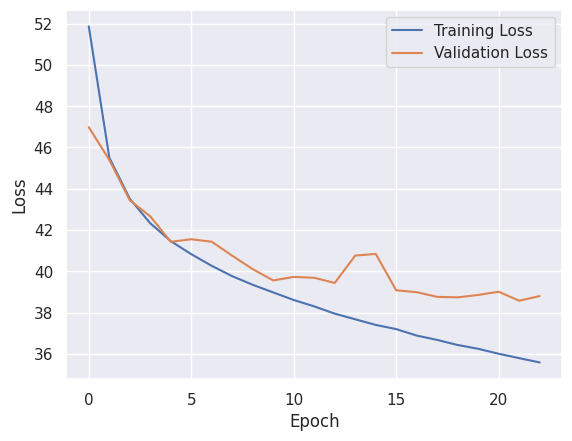

In [ ]:
model = ChessResCNN().to(device)
count_model_parameters(model)
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-3)
schedualer = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
epochs = 23
model, train_losses, val_losses = train_model(model,
                      train_dataloder,
                      val_dataloder,
                      criterion,
                      optimizer,
                      epochs,
                      schedualer,
                      run_name='no_mates_only_evaluation')
plot_losses(train_losses, val_losses)

## Combine 3 Models

### Models Classes

In [18]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        residual = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += residual  # Add skip connection
        return F.relu(out)


class ChessEncoder(nn.Module):
    def __init__(self, dropout, num_res_blocks):
        super(ChessEncoder, self).__init__()
        self.res_blocks64 = nn.Sequential(
            *[ResidualBlock(64) for _ in range(num_res_blocks)],
            nn.Dropout2d(dropout)
        )


        self.conv1 = nn.Sequential(
            nn.Conv2d(12, 32, kernel_size=3, padding=1),  # Input: 12x8x8, Output: 16x8x8
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # Output: 32x8x8
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout2d(dropout)
        )



        self.metadata_projection = nn.Sequential(
            nn.Linear(6, 64),
            nn.BatchNorm1d(64),
            nn.ReLU()
        )
        self.croos_attention = nn.MultiheadAttention(embed_dim=64, num_heads=8, batch_first=True)


    def forward(self, board, metadata):
        metadata_projection = self.metadata_projection(metadata) # shape Nx64
        batch_size = board.size(0)
        board_features = self.conv1(board)
        board_projection = board_features.permute(0, 2, 3, 1).reshape(batch_size, 64, 64) # shape of BATCHx(8*8)xCHANELS
        query = metadata_projection.unsqueeze(1) # shape Nx1x64
        key = board_projection # shape Nx64x64
        value = board_projection # shape Nx64x64
        cross_attention_output, _ = self.croos_attention(query, key, value) # shape Nx1x64
        cross_attention_output = cross_attention_output.squeeze(1).unsqueeze(2).unsqueeze(3) # shape Nx64x1x1
        board_attn_features = board_features + cross_attention_output # shape Nx64x8x8
        board_features = self.res_blocks64(board_attn_features)
        return board_features, metadata_projection


class ChessResHead(nn.Module):
    def __init__(self, encoder, dropout, num_res_blocks):
        super(ChessResHead, self).__init__()
        self.encoder = encoder

        self.res_blocks128 = nn.Sequential(
            *[ResidualBlock(128) for _ in range(num_res_blocks)],
            nn.Dropout2d(dropout)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=1, padding=0),  # Input: 64x8x8, Output: 128x8x8
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout2d(dropout)
        )


        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=1, padding=0),  # Input: 128x8x8, Output: 64x8x8
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.gap = nn.AdaptiveAvgPool2d((1, 1)) # Converts (B, 64, 8, 8) -> (B, 64, 1, 1)

        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(128, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32, 1)  # Predict evaluation score
        )
        self.dropout = nn.Dropout(dropout)


    def forward(self, board, metadata):
        # shape Nx64x8x8, shape Nx64
        board_features, metadata_projection = self.encoder(board, metadata)

        board_features = self.conv2(board_features) # shape Nx128x8
        board_features = self.res_blocks128(board_features)
        board_features = self.conv3(board_features) # shape Nx64x8x8
        board_features = self.gap(board_features) # shape Nx64x1x1
        board_features = board_features.squeeze(2).squeeze(2) # shape Nx64

        combined_features = torch.cat((board_features, metadata_projection), dim=1) # shape Nx128
        combined_features = self.dropout(combined_features)

        # Pass through fully connected layers
        output = self.fc(combined_features)
        return output



class ChessVITHead(nn.Module):
  def __init__(self, encoder, dropout, num_res_blocks, embed_dim=128, nhead=8, cross_nhead=8):
    super(ChessVITHead, self).__init__()
    self.encoder = encoder
    self.patch_ecoder = nn.Conv2d(64, embed_dim, kernel_size=1, padding=0)
    self.flatten = nn.Sequential(
        nn.AdaptiveAvgPool2d((8, 8)),
        nn.Flatten(start_dim=2)
    )
    self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
    self.positional_embedding = nn.Parameter(torch.randn(1, 64 + 1, embed_dim))

    encoder_layers = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=nhead, dropout=dropout)
    self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_res_blocks)

    self.metadata_projection = nn.Sequential(
            nn.Linear(6, embed_dim),
            nn.BatchNorm1d(embed_dim),
            nn.ReLU()
        )
    self.cross_attention = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=cross_nhead, batch_first=True)


    self.fc = nn.Sequential(
            nn.Linear(embed_dim * 2, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32, 1)  # Predict evaluation score
        )




In [19]:
class CombinedModel(nn.Module):
    def __init__(self, mate_model, no_mate_model, is_mate_model, is_mate_threshold=0.5):
        super(CombinedModel, self).__init__()
        self.mate_model = mate_model
        self.no_mate_model = no_mate_model
        self.is_mate_model = is_mate_model
        self.is_mate_model.requires_grad_(False)
        self.is_mate_model.eval()
        self.is_mate_threshold = is_mate_threshold

    def forward(self, board, metadata):
        is_mate_output = self.is_mate_model(board, metadata)
        is_mate_mask = (torch.sigmoid(is_mate_output) > self.is_mate_threshold).float()
        mate_output = self.mate_model(board, metadata)
        no_mate_output = self.no_mate_model(board, metadata)
        combined_output = torch.where(is_mate_mask == 1, mate_output, no_mate_output)
        return combined_output

In [20]:
def create_combined_model(enc_num_res_blocks,
                          encoder_dropout,
                          mate_head_num_res_blocks,
                          mate_head_dropout,
                          no_mate_head_num_res_blocks,
                          no_mate_head_dropout):
    encoder = ChessEncoder(encoder_dropout, enc_num_res_blocks).to(device)
    mate_model = ChessResHead(encoder, mate_head_dropout, mate_head_num_res_blocks).to(device)
    no_mate_model = ChessResHead(encoder, no_mate_head_dropout, no_mate_head_num_res_blocks).to(device)
    is_mate_model = load_checkpoint(IsMateRes(), encoded_data_path + '/is_mate_best_model.pth')
    is_mate_model = is_mate_model.to(device)
    combined_model = CombinedModel(mate_model, no_mate_model, is_mate_model).to(device)
    return combined_model

### Training

#### Optuna

In [ ]:
study_name = "chess-bot-opt-encoder-2heads"
storage_url = f"sqlite:///{encoded_data_path}/{study_name}.db"

##### Optuna Search

In [ ]:
def model_params(trial, model_name):
  return  (trial.suggest_uniform(f'{model_name}_dropout', 0.1, 0.5),
           trial.suggest_int(f'{model_name}_num_res_blocks', 2, 5))


def objective(trial):
    # Suggest hyperparameters
    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    weight_decay = trial.suggest_float('weight_decay', 1e-5, 1e-2, log=True)
    dropout_rate = trial.suggest_uniform('dropout', 0.1, 0.5)
    encoder_dropout, enc_num_res_blocks = model_params(trial, 'encoder')
    mate_head_dropout, mate_head_num_res_blocks = model_params(trial, 'mate_head')
    no_mate_head_dropout, no_mate_head_num_res_blocks = model_params(trial, 'no_mate_head')
    factor = trial.suggest_uniform('factor', 0.1, 0.5)
    patience = trial.suggest_int('patience', 3, 10)

    # Create models
    combined_model = create_combined_model(enc_num_res_blocks,
                                           encoder_dropout,
                                           mate_head_num_res_blocks,
                                           mate_head_dropout,
                                           no_mate_head_num_res_blocks,
                                           no_mate_head_dropout)
    count_model_parameters(combined_model)

    # Loss and Optimizer
    criterion = nn.MSELoss()
    optimizer = optim.AdamW(combined_model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=factor, patience=patience, verbose=True)

    # Train model
    epochs = 15  # Use fewer epochs for faster optimization
    model, train_losses, val_losses = train_model(combined_model, train_dataloder, val_dataloder, criterion, optimizer, epochs, scheduler, run_name=f'optuna_trial_{trial.number}')

    return min(val_losses)


In [ ]:
# Optuna
study = optuna.create_study(
    study_name=study_name,
    direction="minimize",
    pruner=optuna.pruners.MedianPruner(),
    storage=storage_url,
    load_if_exists=True
)
study.optimize(
    objective,
    n_trials=150,
    callbacks=[wandb_callback]
)

# Best parameters
print("Best hyperparameters:", study.best_params)
print("Best validation loss:", study.best_value)

# Save the best parameters for future use
best_params = study.best_params
with open("best_hyperparams.json", "w") as f:
    json.dump(best_params, f)

[I 2025-01-22 17:40:21,470] Using an existing study with name 'chess-bot-opt-encoder-2heads' instead of creating a new one.
<ipython-input-25-08446fb80983>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout', 0.1, 0.5)
<ipython-input-25-08446fb80983>:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  return  (trial.suggest_uniform(f'{model_name}_dropout', 0.1, 0.5),
<ipython-input-25-08446fb80983>:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  factor = trial.suggest_uniform('factor', 0.1, 0.5)
<ipython-input-10-d34ddf04

Model loaded from drive/MyDrive/data/chess_bot_batches/is_mate_best_model.pth
Total parameters: 1434563
Trainable parameters: 1412706


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


optuna_trial_5
Epoch 1, Batch 1, Loss: 85.3459701538086
Epoch 1, Batch 501, Loss: 49.91545104980469
Epoch 1, Batch 1001, Loss: 59.3131217956543
Epoch 1, Batch 1501, Loss: 48.13285446166992
Epoch 1, Batch 2001, Loss: 36.11337661743164
Epoch 1, Batch 2501, Loss: 46.106353759765625
Epoch 1, Batch 3001, Loss: 59.14417266845703
Epoch 1, Batch 3501, Loss: 48.207176208496094
Epoch 1, Batch 4001, Loss: 45.53020477294922
Model saved with loss: 42.361776093975344
Epoch 1, Training Loss: 47.232127304077146, Validation Loss: 42.361776093975344
Epoch 2, Batch 1, Loss: 43.30674362182617
Epoch 2, Batch 501, Loss: 42.892250061035156
Epoch 2, Batch 1001, Loss: 44.78645324707031
Epoch 2, Batch 1501, Loss: 55.388614654541016
Epoch 2, Batch 2001, Loss: 41.76764678955078
Epoch 2, Batch 2501, Loss: 46.707275390625
Epoch 2, Batch 3001, Loss: 33.85895919799805
Epoch 2, Batch 3501, Loss: 33.70915222167969
Epoch 2, Batch 4001, Loss: 37.79420852661133
Model saved with loss: 40.86088291066538
Epoch 2, Training Lo

batch,▄▅▅▆██▁▃▄▁▁▅█▂▃▅▅█▁▃▃▄▅▆▇█▁▂▃▆▅█▄▅▆▅█▁▅▇
batch loss,▃█▅▅▄▄▂▂▂▄▄▄▃▄▂▂▅▃▁▂▄▁▃▂▃▄▄▄▃▄▂▂▃▁▂▃▃▃▄▂
epoch,▁▁▁▁▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇███
train loss,█▅▄▄▃▃▃▂▂▂▂▂▁▁▁
val loss,█▆▅▄▄▃▃▄▃▂▂▂▁▁▁
batch,4001
batch loss,43.30774
epoch,15
train loss,35.7604
val loss,36.0475


[I 2025-01-22 18:58:22,279] Trial 5 finished with value: 36.03115570015639 and parameters: {'lr': 0.0007783172310454971, 'weight_decay': 2.489339820139343e-05, 'dropout': 0.2864904005257832, 'encoder_dropout': 0.12282365502686182, 'encoder_num_res_blocks': 2, 'mate_head_dropout': 0.11050222275138016, 'mate_head_num_res_blocks': 2, 'no_mate_head_dropout': 0.2761219959193203, 'no_mate_head_num_res_blocks': 2, 'factor': 0.4675545250459706, 'patience': 5}. Best is trial 5 with value: 36.03115570015639.


<ipython-input-25-08446fb80983>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout', 0.1, 0.5)
<ipython-input-25-08446fb80983>:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  return  (trial.suggest_uniform(f'{model_name}_dropout', 0.1, 0.5),
<ipython-input-25-08446fb80983>:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  factor = trial.suggest_uniform('factor', 0.1, 0.5)
<ipython-input-10-d34ddf0421bb>:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the de

Model loaded from drive/MyDrive/data/chess_bot_batches/is_mate_best_model.pth
Total parameters: 2543939
Trainable parameters: 2522082
optuna_trial_6
Epoch 1, Batch 1, Loss: 84.64738464355469
Epoch 1, Batch 501, Loss: 48.35023880004883
Epoch 1, Batch 1001, Loss: 43.813140869140625
Epoch 1, Batch 1501, Loss: 65.17322540283203
Epoch 1, Batch 2001, Loss: 53.29505920410156
Epoch 1, Batch 2501, Loss: 56.713111877441406
Epoch 1, Batch 3001, Loss: 65.02069091796875
Epoch 1, Batch 3501, Loss: 40.5169792175293
Epoch 1, Batch 4001, Loss: 51.538185119628906
Model saved with loss: 47.921331759619456
Epoch 1, Training Loss: 50.812351102946714, Validation Loss: 47.921331759619456
Epoch 2, Batch 1, Loss: 36.148475646972656
Epoch 2, Batch 501, Loss: 43.662696838378906
Epoch 2, Batch 1001, Loss: 49.91004180908203
Epoch 2, Batch 1501, Loss: 46.24757385253906
Epoch 2, Batch 2001, Loss: 54.35371017456055
Epoch 2, Batch 2501, Loss: 55.49192428588867
Epoch 2, Batch 3001, Loss: 50.806419372558594
Epoch 2, Bat

batch,▅▅▆▅▅▁▃▅▂▅▁▄▄▁▂█▂▅▇█▄▅█▃▅▇█▂▃▅▇█▁▂▅▅▇▂▃▇
batch loss,██▃▃▁▃▂▄▃▅▁▃▅▃▃▄▃▅▂▄▅▂▃▄▄▃▃▂▆▁▄▄▃▂▂▂▂▂▂▃
dropout,▁
encoder_dropout,▁
encoder_num_res_blocks,▁
epoch,▁▁▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇█
factor,▁
lr,▁
mate_head_dropout,▁
mate_head_num_res_blocks,▁
no_mate_head_dropout,▁


[I 2025-01-22 21:02:51,414] Trial 6 finished with value: 43.85159314937911 and parameters: {'lr': 0.005045274394093087, 'weight_decay': 5.021801738690749e-05, 'dropout': 0.16132397575492582, 'encoder_dropout': 0.46773727730665426, 'encoder_num_res_blocks': 5, 'mate_head_dropout': 0.45847943440354544, 'mate_head_num_res_blocks': 4, 'no_mate_head_dropout': 0.14746422410522625, 'no_mate_head_num_res_blocks': 3, 'factor': 0.4346888630706859, 'patience': 7}. Best is trial 5 with value: 36.03115570015639.


Model loaded from drive/MyDrive/data/chess_bot_batches/is_mate_best_model.pth
Total parameters: 3135299
Trainable parameters: 3113442
optuna_trial_7
Epoch 1, Batch 1, Loss: 56.56996536254883
Epoch 1, Batch 501, Loss: 47.77671813964844
Epoch 1, Batch 1001, Loss: 56.51976776123047
Epoch 1, Batch 1501, Loss: 51.28706741333008
Epoch 1, Batch 2001, Loss: 39.503273010253906
Epoch 1, Batch 2501, Loss: 57.586585998535156
Epoch 1, Batch 3001, Loss: 37.65450668334961
Epoch 1, Batch 3501, Loss: 56.34095764160156
Epoch 1, Batch 4001, Loss: 40.22150421142578
Model saved with loss: 49.05262259834493
Epoch 1, Training Loss: 50.61402113361123, Validation Loss: 49.05262259834493
Epoch 2, Batch 1, Loss: 44.77134704589844
Epoch 2, Batch 501, Loss: 56.353370666503906
Epoch 2, Batch 1001, Loss: 39.735164642333984
Epoch 2, Batch 1501, Loss: 42.0012321472168
Epoch 2, Batch 2001, Loss: 56.39224624633789
Epoch 2, Batch 2501, Loss: 53.905723571777344
Epoch 2, Batch 3001, Loss: 46.45250701904297
Epoch 2, Batch 3

batch,▃▄▅▁▂▇▁▂▅▇▅▇▃▄▅▄▅▆▇▂▄▇█▄▅▄▁▂▄▅▃▄▅▇▃█▁▂▄▅
batch loss,▄▅▄▄█▅▄▃▅▆▅█▄▅▃▄▂▅▄▅▂▅▆▅▄▃▄▂▁▃▂▄▇▅▄▅▆▂▃▂
dropout,▁
encoder_dropout,▁
encoder_num_res_blocks,▁
epoch,▁▁▁▁▁▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇█
factor,▁
lr,▁
mate_head_dropout,▁
mate_head_num_res_blocks,▁
no_mate_head_dropout,▁


[I 2025-01-22 23:19:27,914] Trial 7 finished with value: 47.10297806712506 and parameters: {'lr': 0.0028614905076584604, 'weight_decay': 0.0016847056841672293, 'dropout': 0.3960407574752295, 'encoder_dropout': 0.43469994277369406, 'encoder_num_res_blocks': 5, 'mate_head_dropout': 0.33057036949272334, 'mate_head_num_res_blocks': 5, 'no_mate_head_dropout': 0.25856652798451474, 'no_mate_head_num_res_blocks': 4, 'factor': 0.238108119981141, 'patience': 9}. Best is trial 5 with value: 36.03115570015639.


Model loaded from drive/MyDrive/data/chess_bot_batches/is_mate_best_model.pth
Total parameters: 1878467
Trainable parameters: 1856610
optuna_trial_8
Epoch 1, Batch 1, Loss: 72.67864227294922
Epoch 1, Batch 501, Loss: 56.31828308105469
Epoch 1, Batch 1001, Loss: 66.20803833007812
Epoch 1, Batch 1501, Loss: 58.297340393066406
Epoch 1, Batch 2001, Loss: 62.923683166503906
Epoch 1, Batch 2501, Loss: 45.081695556640625
Epoch 1, Batch 3001, Loss: 52.960174560546875
Epoch 1, Batch 3501, Loss: 49.04624557495117
Epoch 1, Batch 4001, Loss: 45.003570556640625
Model saved with loss: 54.02328037815527
Epoch 1, Training Loss: 53.042720796090585, Validation Loss: 54.02328037815527
Epoch 2, Batch 1, Loss: 49.853797912597656
Epoch 2, Batch 501, Loss: 50.1374397277832
Epoch 2, Batch 1001, Loss: 43.30266189575195
Epoch 2, Batch 1501, Loss: 46.94599914550781
Epoch 2, Batch 2001, Loss: 41.82775115966797
Epoch 2, Batch 2501, Loss: 46.52428436279297
Epoch 2, Batch 3001, Loss: 37.560394287109375
Epoch 2, Batc

batch,▃▆▇▂▄█▁▄▆▇█▁▂▃▆█▃▅▆█▆▂▃▅▆▆▇█▃▅▇█▂▄▅▇█▅▆█
batch loss,▇█▄▅▄▃▂▃▂▆▄▇▆▅▄▃▄▄▃▂▂▄▅▆▄▄▂▃▃▅▃▂▂▄▁▄▃▃▃▃
dropout,▁
encoder_dropout,▁
encoder_num_res_blocks,▁
epoch,▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇█
factor,▁
lr,▁
mate_head_dropout,▁
mate_head_num_res_blocks,▁
no_mate_head_dropout,▁


[I 2025-01-23 01:01:09,230] Trial 8 finished with value: 44.14058809948815 and parameters: {'lr': 0.00020538810156837524, 'weight_decay': 0.000782166524340575, 'dropout': 0.15244267364394673, 'encoder_dropout': 0.4942303671284025, 'encoder_num_res_blocks': 4, 'mate_head_dropout': 0.4611372950127832, 'mate_head_num_res_blocks': 2, 'no_mate_head_dropout': 0.2655696238408572, 'no_mate_head_num_res_blocks': 3, 'factor': 0.4274193807010983, 'patience': 4}. Best is trial 5 with value: 36.03115570015639.


Model loaded from drive/MyDrive/data/chess_bot_batches/is_mate_best_model.pth
Total parameters: 2321603
Trainable parameters: 2299746
optuna_trial_9
Epoch 1, Batch 1, Loss: 72.92189025878906
Epoch 1, Batch 501, Loss: 61.83934020996094
Epoch 1, Batch 1001, Loss: 57.612586975097656
Epoch 1, Batch 1501, Loss: 46.127967834472656
Epoch 1, Batch 2001, Loss: 57.38741683959961
Epoch 1, Batch 2501, Loss: 49.36375427246094
Epoch 1, Batch 3001, Loss: 72.47039031982422
Epoch 1, Batch 3501, Loss: 58.747276306152344
Epoch 1, Batch 4001, Loss: 51.5347900390625
Model saved with loss: 51.817458268567584
Epoch 1, Training Loss: 54.91590063777971, Validation Loss: 51.817458268567584
Epoch 2, Batch 1, Loss: 61.5537223815918
Epoch 2, Batch 501, Loss: 46.527462005615234
Epoch 2, Batch 1001, Loss: 49.06593704223633
Epoch 2, Batch 1501, Loss: 44.223445892333984
Epoch 2, Batch 2001, Loss: 54.521575927734375
Epoch 2, Batch 2501, Loss: 55.40734100341797
Epoch 2, Batch 3001, Loss: 46.367218017578125
Epoch 2, Batc

batch,▂▃▅█▂▄▅▅▆▇▇█▁▆█▅▂▅▅▆▃▅▇█▅▂▃▅▇█▃▅▇▁▂▅▆▃▅▇
batch loss,█▄█▅▃▃▅▄▃▄▃▅▃▄▃▄▂▁▃▃▃▄▃▅▄▃▄▄▂▄▃▂▃▃▃▃▃▃▂▃
dropout,▁
encoder_dropout,▁
encoder_num_res_blocks,▁
epoch,▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇██
factor,▁
lr,▁
mate_head_dropout,▁
mate_head_num_res_blocks,▁
no_mate_head_dropout,▁


[I 2025-01-23 02:39:14,864] Trial 9 finished with value: 43.456048089918944 and parameters: {'lr': 9.338708199315754e-05, 'weight_decay': 1.3882428878716451e-05, 'dropout': 0.20325495821516745, 'encoder_dropout': 0.44017117696089614, 'encoder_num_res_blocks': 2, 'mate_head_dropout': 0.342339396990421, 'mate_head_num_res_blocks': 5, 'no_mate_head_dropout': 0.33080699010963943, 'no_mate_head_num_res_blocks': 2, 'factor': 0.3609078657563589, 'patience': 8}. Best is trial 5 with value: 36.03115570015639.


Model loaded from drive/MyDrive/data/chess_bot_batches/is_mate_best_model.pth
Total parameters: 2765507
Trainable parameters: 2743650
optuna_trial_10
Epoch 1, Batch 1, Loss: 62.58270263671875
Epoch 1, Batch 501, Loss: 51.24138641357422
Epoch 1, Batch 1001, Loss: 44.55086898803711
Epoch 1, Batch 1501, Loss: 47.109798431396484
Epoch 1, Batch 2001, Loss: 47.73625183105469
Epoch 1, Batch 2501, Loss: 51.64438247680664
Epoch 1, Batch 3001, Loss: 44.254638671875
Epoch 1, Batch 3501, Loss: 51.99114227294922
Epoch 1, Batch 4001, Loss: 62.412994384765625
Model saved with loss: 45.431348226383435
Epoch 1, Training Loss: 48.71475934299422, Validation Loss: 45.431348226383435
Epoch 2, Batch 1, Loss: 35.96112060546875
Epoch 2, Batch 501, Loss: 40.95423889160156
Epoch 2, Batch 1001, Loss: 37.676292419433594
Epoch 2, Batch 1501, Loss: 44.091392517089844
Epoch 2, Batch 2001, Loss: 40.878074645996094
Epoch 2, Batch 2501, Loss: 45.895233154296875
Epoch 2, Batch 3001, Loss: 55.57794952392578
Epoch 2, Batc

batch,▄▅▆▇▄▄▅▅▇▁▅▅▁▅█▄▆▇▁▇▃▅▆▄▅▇▅█▃▆▆▇█▅▇▃▄▅█▆
batch loss,▇▅▅█▆▃▄▅▄▄█▄▅▂▃▄▃▃▂▂▄▄▃▂▄▂▃▃▁▂▄▃▁▅▅█▂▅▃▃
dropout,▁
encoder_dropout,▁
encoder_num_res_blocks,▁
epoch,▁▁▁▁▁▁▁▁▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇▇▇▇█
factor,▁
lr,▁
mate_head_dropout,▁
mate_head_num_res_blocks,▁
no_mate_head_dropout,▁


[I 2025-01-23 04:39:40,893] Trial 10 finished with value: 39.890092102231534 and parameters: {'lr': 0.0012885640291945219, 'weight_decay': 1.346869117558646e-05, 'dropout': 0.19892202246791924, 'encoder_dropout': 0.3338648739039228, 'encoder_num_res_blocks': 4, 'mate_head_dropout': 0.219522484231037, 'mate_head_num_res_blocks': 4, 'no_mate_head_dropout': 0.20967701334558841, 'no_mate_head_num_res_blocks': 4, 'factor': 0.3722737536794135, 'patience': 4}. Best is trial 5 with value: 36.03115570015639.


Model loaded from drive/MyDrive/data/chess_bot_batches/is_mate_best_model.pth
Total parameters: 2839619
Trainable parameters: 2817762
optuna_trial_11
Epoch 1, Batch 1, Loss: 64.06881713867188
Epoch 1, Batch 501, Loss: 55.272186279296875
Epoch 1, Batch 1001, Loss: 65.06087493896484
Epoch 1, Batch 1501, Loss: 55.17375183105469
Epoch 1, Batch 2001, Loss: 57.597862243652344
Epoch 1, Batch 2501, Loss: 62.297489166259766
Epoch 1, Batch 3001, Loss: 48.392547607421875
Epoch 1, Batch 3501, Loss: 59.8716926574707
Epoch 1, Batch 4001, Loss: 53.392333984375
Model saved with loss: 47.68535265870767
Epoch 1, Training Loss: 51.798043850557306, Validation Loss: 47.68535265870767
Epoch 2, Batch 1, Loss: 52.58210754394531
Epoch 2, Batch 501, Loss: 50.14432907104492
Epoch 2, Batch 1001, Loss: 41.97887420654297
Epoch 2, Batch 1501, Loss: 31.427343368530273
Epoch 2, Batch 2001, Loss: 50.20816421508789
Epoch 2, Batch 2501, Loss: 36.057220458984375
Epoch 2, Batch 3001, Loss: 42.97892379760742
Epoch 2, Batch 

batch,▅▁▅▅█▅▆▁▄▅▇▅█▅▆▆▇▂▃▄▄▅▇█▂▅█▁▂▄▁▃▄▅▆▃▄▅▂▄
batch loss,█▃▅▆▆▅▆▄▂▄▃▇▃▆▃▅▆█▄▄▇▄▃▃▄▇▄▄▅▇▅▆▁▃▅▅▅▄▄▇
dropout,▁
encoder_dropout,▁
encoder_num_res_blocks,▁
epoch,▁▁▁▁▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇▇██████
factor,▁
lr,▁
mate_head_dropout,▁
mate_head_num_res_blocks,▁
no_mate_head_dropout,▁


[I 2025-01-23 06:49:48,016] Trial 11 finished with value: 41.37616354480077 and parameters: {'lr': 0.00019100715324844286, 'weight_decay': 0.0009197496398158994, 'dropout': 0.3619209661295324, 'encoder_dropout': 0.3449878289568913, 'encoder_num_res_blocks': 5, 'mate_head_dropout': 0.4934682123526626, 'mate_head_num_res_blocks': 3, 'no_mate_head_dropout': 0.4159937594317632, 'no_mate_head_num_res_blocks': 5, 'factor': 0.14415134669856355, 'patience': 7}. Best is trial 5 with value: 36.03115570015639.


Model loaded from drive/MyDrive/data/chess_bot_batches/is_mate_best_model.pth
Total parameters: 2174147
Trainable parameters: 2152290
optuna_trial_12
Epoch 1, Batch 1, Loss: 61.656898498535156
Epoch 1, Batch 501, Loss: 63.38017654418945
Epoch 1, Batch 1001, Loss: 42.73093795776367
Epoch 1, Batch 1501, Loss: 49.1694450378418
Epoch 1, Batch 2001, Loss: 42.10054397583008
Epoch 1, Batch 2501, Loss: 51.469844818115234
Epoch 1, Batch 3001, Loss: 47.26323699951172
Epoch 1, Batch 3501, Loss: 52.33477783203125
Epoch 1, Batch 4001, Loss: 43.54085159301758
Model saved with loss: 43.73123755271437
Epoch 1, Training Loss: 47.98489434889805, Validation Loss: 43.73123755271437
Epoch 2, Batch 1, Loss: 38.93304443359375
Epoch 2, Batch 501, Loss: 33.63255310058594
Epoch 2, Batch 1001, Loss: 45.728858947753906
Epoch 2, Batch 1501, Loss: 45.762657165527344
Epoch 2, Batch 2001, Loss: 46.30319595336914
Epoch 2, Batch 2501, Loss: 40.55421447753906
Epoch 2, Batch 3001, Loss: 38.869815826416016
Epoch 2, Batch 

batch,▁▃▅▆█▂█▂▃▄▆█▂▅▆▅▆▇█▂▃▄▇▂▃▁▅▆▂▃▅█▆▇▁▆█▂▄▅
batch loss,▅▇██▄▇▇▅▃▄▅▆▄▄▂▄▄▅▄▂▂▂▄▃▂▄▅▄▅▆▁▆▂▆▃▅▃▆▇▅
dropout,▁
encoder_dropout,▁
encoder_num_res_blocks,▁
epoch,▁▁▁▁▁▁▁▁▁▂▃▃▃▃▃▄▅▅▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇▇▇██
factor,▁
lr,▁
mate_head_dropout,▁
mate_head_num_res_blocks,▁
no_mate_head_dropout,▁


[I 2025-01-23 08:38:23,196] Trial 12 finished with value: 37.811342546287904 and parameters: {'lr': 0.0073684608827485135, 'weight_decay': 5.7980755051041856e-05, 'dropout': 0.4412785538707934, 'encoder_dropout': 0.18570174558146083, 'encoder_num_res_blocks': 4, 'mate_head_dropout': 0.1502174488466852, 'mate_head_num_res_blocks': 2, 'no_mate_head_dropout': 0.14619310855952006, 'no_mate_head_num_res_blocks': 4, 'factor': 0.2328695787626589, 'patience': 9}. Best is trial 5 with value: 36.03115570015639.


Model loaded from drive/MyDrive/data/chess_bot_batches/is_mate_best_model.pth
Total parameters: 2025923
Trainable parameters: 2004066
optuna_trial_13
Epoch 1, Batch 1, Loss: 77.56940460205078
Epoch 1, Batch 501, Loss: 54.56248474121094
Epoch 1, Batch 1001, Loss: 61.195858001708984
Epoch 1, Batch 1501, Loss: 41.41508483886719
Epoch 1, Batch 2001, Loss: 58.26506423950195
Epoch 1, Batch 2501, Loss: 49.05622100830078
Epoch 1, Batch 3001, Loss: 54.909400939941406
Epoch 1, Batch 3501, Loss: 53.10560989379883
Epoch 1, Batch 4001, Loss: 63.46721267700195
Model saved with loss: 56.686666957482416
Epoch 1, Training Loss: 60.58537549996082, Validation Loss: 56.686666957482416
Epoch 2, Batch 1, Loss: 47.936954498291016
Epoch 2, Batch 501, Loss: 56.98503875732422
Epoch 2, Batch 1001, Loss: 61.08638000488281
Epoch 2, Batch 1501, Loss: 57.450653076171875
Epoch 2, Batch 2001, Loss: 49.71537780761719
Epoch 2, Batch 2501, Loss: 70.49188232421875
Epoch 2, Batch 3001, Loss: 52.34496307373047
Epoch 2, Batc

batch,▅▁▂▄▅▂▅▇█▁▆▂▄▅▁▄▅█▁▂▄▇█▅▆▂▃▅▅▅▅▁▇▁▂▅▁▂▅█
batch loss,▅▄▅▄▆▆▄█▇▇▄▇▄▆▃▂▁▄▅▃▅▃▆▄▃▅▄▁▆▇▁▆▅█▅▁▁▄▁▆
dropout,▁
encoder_dropout,▁
encoder_num_res_blocks,▁
epoch,▁▁▁▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▅▅▆▇▇▇▇▇▇▇▇▇▇▇▇▇█
factor,▁
lr,▁
mate_head_dropout,▁
mate_head_num_res_blocks,▁
no_mate_head_dropout,▁


[I 2025-01-23 10:08:27,370] Trial 13 finished with value: 52.52965112029035 and parameters: {'lr': 1.4032539214036085e-05, 'weight_decay': 1.2515087202152029e-05, 'dropout': 0.14203637818545, 'encoder_dropout': 0.49531714547464956, 'encoder_num_res_blocks': 2, 'mate_head_dropout': 0.2521757167687224, 'mate_head_num_res_blocks': 4, 'no_mate_head_dropout': 0.3058188896643552, 'no_mate_head_num_res_blocks': 2, 'factor': 0.38529821616086757, 'patience': 3}. Best is trial 5 with value: 36.03115570015639.


Model loaded from drive/MyDrive/data/chess_bot_batches/is_mate_best_model.pth
Total parameters: 2765507
Trainable parameters: 2743650
optuna_trial_14
Epoch 1, Batch 1, Loss: 65.97209167480469
Epoch 1, Batch 501, Loss: 57.218963623046875
Epoch 1, Batch 1001, Loss: 65.95756530761719
Epoch 1, Batch 1501, Loss: 46.109580993652344
Epoch 1, Batch 2001, Loss: 57.76264190673828
Epoch 1, Batch 2501, Loss: 67.01749420166016
Epoch 1, Batch 3001, Loss: 64.11454772949219
Epoch 1, Batch 3501, Loss: 60.301578521728516
Epoch 1, Batch 4001, Loss: 45.6428108215332
Model saved with loss: 50.765360712652026
Epoch 1, Training Loss: 56.43448744974019, Validation Loss: 50.765360712652026
Epoch 2, Batch 1, Loss: 42.65007781982422
Epoch 2, Batch 501, Loss: 45.24810028076172
Epoch 2, Batch 1001, Loss: 55.30961227416992
Epoch 2, Batch 1501, Loss: 41.91388702392578
Epoch 2, Batch 2001, Loss: 57.17976379394531
Epoch 2, Batch 2501, Loss: 36.311885833740234
Epoch 2, Batch 3001, Loss: 52.842254638671875
Epoch 2, Batc

batch,▂▃▄▆▂▅▁▂▃▄▃▄▅▆▇▄▅▄▆▇▂▄▁▅▁▅▇█▁▃▂▄▇▁▂▅▁▂▄▇
batch loss,▆▄▆█▇▃▅▃▄▄▄▃▅▅▂▁▄▄▅▂▃▂▁▄▂▅▃▂▄▄▁▃▅▂▂▃▃▃▅▃
dropout,▁
encoder_dropout,▁
encoder_num_res_blocks,▁
epoch,▁▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▅▅▅▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇███
factor,▁
lr,▁
mate_head_dropout,▁
mate_head_num_res_blocks,▁
no_mate_head_dropout,▁


[I 2025-01-23 12:10:44,322] Trial 14 finished with value: 40.654777157812696 and parameters: {'lr': 2.9851487378164403e-05, 'weight_decay': 3.247925569499494e-05, 'dropout': 0.2651013917645564, 'encoder_dropout': 0.1646830923352375, 'encoder_num_res_blocks': 4, 'mate_head_dropout': 0.34458173142181936, 'mate_head_num_res_blocks': 5, 'no_mate_head_dropout': 0.4458344974645281, 'no_mate_head_num_res_blocks': 3, 'factor': 0.32303372439944145, 'patience': 9}. Best is trial 5 with value: 36.03115570015639.


Model loaded from drive/MyDrive/data/chess_bot_batches/is_mate_best_model.pth
Total parameters: 1804355
Trainable parameters: 1782498
optuna_trial_15
Epoch 1, Batch 1, Loss: 60.106056213378906
Epoch 1, Batch 501, Loss: 46.032142639160156
Epoch 1, Batch 1001, Loss: 49.80405044555664
Epoch 1, Batch 1501, Loss: 48.81083679199219
Epoch 1, Batch 2001, Loss: 42.1955451965332
Epoch 1, Batch 2501, Loss: 31.132047653198242
Epoch 1, Batch 3001, Loss: 47.58284378051758
Epoch 1, Batch 3501, Loss: 43.02259063720703
Epoch 1, Batch 4001, Loss: 41.96669006347656
Model saved with loss: 43.8935946495606
Epoch 1, Training Loss: 48.22322013949171, Validation Loss: 43.8935946495606
Epoch 2, Batch 1, Loss: 45.712406158447266
Epoch 2, Batch 501, Loss: 40.748817443847656
Epoch 2, Batch 1001, Loss: 42.54197692871094
Epoch 2, Batch 1501, Loss: 40.546844482421875
Epoch 2, Batch 2001, Loss: 36.22917175292969
Epoch 2, Batch 2501, Loss: 49.50981521606445
Epoch 2, Batch 3001, Loss: 50.46229553222656
Epoch 2, Batch 3

batch,▅▆▇█▃▁▄▆▁▂▅█▃▄▆▁▂▃▅▂▅▆▅▆▇▆▇▁▃▄▁▂▃▄▅▁█▃▅▅
batch loss,▆▂▅▅▃▅▅▅▇▃▆▅█▄▆▆▅▃▄▆▂▄▃▃▃▄▂█▃▃▃▂▁▅▃▄▆▁▁▃
dropout,▁
encoder_dropout,▁
encoder_num_res_blocks,▁
epoch,▁▁▁▁▁▁▁▂▂▂▃▃▃▃▃▄▄▅▅▅▅▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇█
factor,▁
lr,▁
mate_head_dropout,▁
mate_head_num_res_blocks,▁
no_mate_head_dropout,▁


[I 2025-01-23 13:44:33,212] Trial 15 finished with value: 37.358255009778276 and parameters: {'lr': 0.0007548657006227979, 'weight_decay': 0.009511937274595945, 'dropout': 0.30072885986682724, 'encoder_dropout': 0.23751016844964695, 'encoder_num_res_blocks': 3, 'mate_head_dropout': 0.10111082510460093, 'mate_head_num_res_blocks': 3, 'no_mate_head_dropout': 0.39633477986504373, 'no_mate_head_num_res_blocks': 2, 'factor': 0.465264244806893, 'patience': 5}. Best is trial 5 with value: 36.03115570015639.


Model loaded from drive/MyDrive/data/chess_bot_batches/is_mate_best_model.pth
Total parameters: 1804355
Trainable parameters: 1782498
optuna_trial_16
Epoch 1, Batch 1, Loss: 78.59700012207031
Epoch 1, Batch 501, Loss: 47.954246520996094
Epoch 1, Batch 1001, Loss: 47.249420166015625
Epoch 1, Batch 1501, Loss: 52.16815948486328
Epoch 1, Batch 2001, Loss: 41.1668701171875
Epoch 1, Batch 2501, Loss: 44.14210891723633
Epoch 1, Batch 3001, Loss: 38.12353515625
Epoch 1, Batch 3501, Loss: 57.6434326171875
Epoch 1, Batch 4001, Loss: 39.240760803222656
Model saved with loss: 42.892147640367604
Epoch 1, Training Loss: 48.405069760923034, Validation Loss: 42.892147640367604
Epoch 2, Batch 1, Loss: 44.47013473510742
Epoch 2, Batch 501, Loss: 43.794063568115234
Epoch 2, Batch 1001, Loss: 52.52934265136719
Epoch 2, Batch 1501, Loss: 35.365638732910156
Epoch 2, Batch 2001, Loss: 51.560821533203125
Epoch 2, Batch 2501, Loss: 41.177734375
Epoch 2, Batch 3001, Loss: 49.25946044921875
Epoch 2, Batch 3501,

batch,▄▆▇▃▄█▁▃▄▅▄▅▅▇▃▇▂▃▆▇▃▄▅▆█▃▄▁▂▃▇▁▅▇▄▂▅█▂▅
batch loss,▇▆▄█▅▅▇▅▅▄▄▂▃▅▅█▄▃▃▆▃▃▅▁▄▃▆▆▃█▄▂▄▃▄▄▂▄▃▇
dropout,▁
encoder_dropout,▁
encoder_num_res_blocks,▁
epoch,▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇██
factor,▁
lr,▁
mate_head_dropout,▁
mate_head_num_res_blocks,▁
no_mate_head_dropout,▁


[I 2025-01-23 15:18:03,870] Trial 16 finished with value: 37.53248194010095 and parameters: {'lr': 0.0007808276300191354, 'weight_decay': 0.00893313305635259, 'dropout': 0.31315842860756077, 'encoder_dropout': 0.23511006462838868, 'encoder_num_res_blocks': 3, 'mate_head_dropout': 0.10289756145109015, 'mate_head_num_res_blocks': 3, 'no_mate_head_dropout': 0.37392355056376175, 'no_mate_head_num_res_blocks': 2, 'factor': 0.48773422752707474, 'patience': 5}. Best is trial 5 with value: 36.03115570015639.


Model loaded from drive/MyDrive/data/chess_bot_batches/is_mate_best_model.pth
Total parameters: 1508675
Trainable parameters: 1486818
optuna_trial_17
Epoch 1, Batch 1, Loss: 65.4706802368164
Epoch 1, Batch 501, Loss: 53.48235321044922
Epoch 1, Batch 1001, Loss: 50.56732940673828
Epoch 1, Batch 1501, Loss: 48.05754852294922
Epoch 1, Batch 2001, Loss: 43.89479064941406
Epoch 1, Batch 2501, Loss: 51.301849365234375
Epoch 1, Batch 3001, Loss: 43.31303787231445
Epoch 1, Batch 3501, Loss: 52.54125213623047
Epoch 1, Batch 4001, Loss: 43.47018814086914
Model saved with loss: 43.111388960571894
Epoch 1, Training Loss: 47.36718501997583, Validation Loss: 43.111388960571894
Epoch 2, Batch 1, Loss: 44.89701461791992
Epoch 2, Batch 501, Loss: 36.859962463378906
Epoch 2, Batch 1001, Loss: 41.479164123535156
Epoch 2, Batch 1501, Loss: 40.135223388671875
Epoch 2, Batch 2001, Loss: 62.87104034423828
Epoch 2, Batch 2501, Loss: 37.71314239501953
Epoch 2, Batch 3001, Loss: 35.049591064453125
Epoch 2, Batc

batch,▂▅▆▁▂▁▂▅▇▂█▂▂▃▆▁▅▆▇█▄▅▆▄▅█▂▄▁▂▄█▂▃▆▂▅█▅▇
batch loss,▅▄▄▆▄▄█▃▆▆▂▄▇▂▃▃▅▅▃▅▂▄▅▃▄▄▃▃▄▄▄▂▃▄▄▃▃▃▁▂
dropout,▁
encoder_dropout,▁
encoder_num_res_blocks,▁
epoch,▁▁▁▁▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▅▅▇▇▇▇▇▇▇▇██
factor,▁
lr,▁
mate_head_dropout,▁
mate_head_num_res_blocks,▁
no_mate_head_dropout,▁


[I 2025-01-23 16:45:11,707] Trial 17 finished with value: 35.67624933933811 and parameters: {'lr': 0.0006411087225408217, 'weight_decay': 0.00021151575945070833, 'dropout': 0.2792976616608437, 'encoder_dropout': 0.10891996514429646, 'encoder_num_res_blocks': 3, 'mate_head_dropout': 0.10359688689035476, 'mate_head_num_res_blocks': 2, 'no_mate_head_dropout': 0.49708234536631246, 'no_mate_head_num_res_blocks': 2, 'factor': 0.4939741902162411, 'patience': 5}. Best is trial 17 with value: 35.67624933933811.


Model loaded from drive/MyDrive/data/chess_bot_batches/is_mate_best_model.pth
Total parameters: 1434563
Trainable parameters: 1412706
optuna_trial_18
Epoch 1, Batch 1, Loss: 83.04120635986328
Epoch 1, Batch 501, Loss: 45.972198486328125
Epoch 1, Batch 1001, Loss: 46.749515533447266
Epoch 1, Batch 1501, Loss: 43.229454040527344
Epoch 1, Batch 2001, Loss: 48.90898132324219
Epoch 1, Batch 2501, Loss: 47.55519104003906
Epoch 1, Batch 3001, Loss: 53.59405517578125
Epoch 1, Batch 3501, Loss: 39.804176330566406
Epoch 1, Batch 4001, Loss: 36.7078857421875
Model saved with loss: 44.20442586072223
Epoch 1, Training Loss: 47.77632590541133, Validation Loss: 44.20442586072223
Epoch 2, Batch 1, Loss: 47.97246551513672
Epoch 2, Batch 501, Loss: 42.49267578125
Epoch 2, Batch 1001, Loss: 44.342742919921875
Epoch 2, Batch 1501, Loss: 45.960784912109375
Epoch 2, Batch 2001, Loss: 41.046607971191406
Epoch 2, Batch 2501, Loss: 29.67624855041504
Epoch 2, Batch 3001, Loss: 28.95631980895996
Epoch 2, Batch 3

In [ ]:
print("Best hyperparameters:", study.best_params)
print("Best validation loss:", study.best_value)

##### Run with optuna params

In [ ]:
study = optuna.load_study(study_name=study_name, storage=storage_url)

In [ ]:
params = study.best_params
print(study.best_value)
params

35.67624933933811


{'lr': 0.0006411087225408217,
 'weight_decay': 0.00021151575945070833,
 'dropout': 0.2792976616608437,
 'encoder_dropout': 0.10891996514429646,
 'encoder_num_res_blocks': 3,
 'mate_head_dropout': 0.10359688689035476,
 'mate_head_num_res_blocks': 2,
 'no_mate_head_dropout': 0.49708234536631246,
 'no_mate_head_num_res_blocks': 2,
 'factor': 0.4939741902162411,
 'patience': 5}

In [ ]:
# params = {'lr': 6.860104352666513e-05,
#  'weight_decay': 1.0348212336731656e-05,
#  'dropout': 0.3759278458136376,
#  'encoder_dropout': 0.16934309263497205,
#  'encoder_num_res_blocks': 5,
#  'mate_head_dropout': 0.3525041126657412,
#  'mate_head_num_res_blocks': 4,
#  'no_mate_head_dropout': 0.14844423212296182,
#  'no_mate_head_num_res_blocks': 2,
#  'factor': 0.23898104177634294,
#  'patience': 8}

In [ ]:
params = study.best_params
params

{'lr': 0.0006411087225408217,
 'weight_decay': 0.00021151575945070833,
 'dropout': 0.2792976616608437,
 'encoder_dropout': 0.10891996514429646,
 'encoder_num_res_blocks': 3,
 'mate_head_dropout': 0.10359688689035476,
 'mate_head_num_res_blocks': 2,
 'no_mate_head_dropout': 0.49708234536631246,
 'no_mate_head_num_res_blocks': 2,
 'factor': 0.4939741902162411,
 'patience': 5}

In [ ]:
# combined_model_ct = create_combined_model(params['encoder_num_res_blocks'],
#                                        params['encoder_dropout'],
#                                        params['mate_head_num_res_blocks'],
#                                        params['mate_head_dropout'],
#                                        params['no_mate_head_num_res_blocks'],
#                                        params['no_mate_head_dropout'])
# combined_model_ct = load_checkpoint(combined_model_ct, encoded_data_path + '/optuna_best_params_best_model.pth')

In [ ]:
combined_model = create_combined_model(params['encoder_num_res_blocks'],
                                       params['encoder_dropout'],
                                       params['mate_head_num_res_blocks'],
                                       params['mate_head_dropout'],
                                       params['no_mate_head_num_res_blocks'],
                                       params['no_mate_head_dropout'])


# Loss and Optimizer
criterion = nn.MSELoss()
optimizer = optim.AdamW(combined_model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=params['factor'], patience=params['patience'], verbose=True)

# Train model
epochs = 50
model, train_losses, val_losses = train_model(combined_model, train_dataloder, val_dataloder, criterion, optimizer, epochs, scheduler, run_name='optuna_best_params')

<ipython-input-10-d34ddf0421bb>:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Model loaded from drive/MyDrive/data/chess_bot_batches/is_mate_best_model.pth


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


optuna_best_params
Epoch 1, Batch 1, Loss: 72.36067199707031
Epoch 1, Batch 501, Loss: 40.12980270385742
Epoch 1, Batch 1001, Loss: 47.56634521484375
Epoch 1, Batch 1501, Loss: 38.61085510253906
Epoch 1, Batch 2001, Loss: 45.526954650878906
Epoch 1, Batch 2501, Loss: 40.68177795410156
Epoch 1, Batch 3001, Loss: 43.795806884765625
Epoch 1, Batch 3501, Loss: 48.263702392578125
Epoch 1, Batch 4001, Loss: 37.36011505126953
Model saved with loss: 43.144217525983024
Epoch 1, Training Loss: 47.52597654413294, Validation Loss: 43.144217525983024
Epoch 2, Batch 1, Loss: 46.47047424316406
Epoch 2, Batch 501, Loss: 52.865867614746094
Epoch 2, Batch 1001, Loss: 48.6254768371582
Epoch 2, Batch 1501, Loss: 51.968170166015625
Epoch 2, Batch 2001, Loss: 46.68024826049805
Epoch 2, Batch 2501, Loss: 45.77792739868164
Epoch 2, Batch 3001, Loss: 42.82417297363281
Epoch 2, Batch 3501, Loss: 33.49560546875
Epoch 2, Batch 4001, Loss: 45.39158630371094
Model saved with loss: 41.85369435467584
Epoch 2, Trainin

batch,▅▅▄▂▃▇█▁▅▅█▆▅▃▇▁▂▂▄▅▇▃▅▆▁▆▂▇█▇▇▅▅█▂▂▂▄▅█
batch loss,▆█▅▆▄▅▃▅▆▆▄▅▄▃▅▇▅▄▅▄▅▆▄▂▄▃▅▃▃▃▄▅▂▃▅▁▃▂▄▃
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
train loss,█▆▅▅▅▄▄▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val loss,█▇▅▄▄▄▃▃▃▃▂▂▂▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁
batch,4001
batch loss,34.64832
epoch,50
train loss,26.875
val loss,35.34826


#### Normal run

In [ ]:
model = create_combined_model()
count_model_parameters(model)
criterion = nn.MSELoss()  # Loss for regression task
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-3)
schedualer = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
epochs = 150
model, com_train_losses, com_val_losses = train_model(model, train_dataloder, val_dataloder, criterion, optimizer, epochs, schedualer, run_name='combined_evaluation_model')
plot_losses(com_train_losses, com_val_losses)

<ipython-input-34-d34ddf0421bb>:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Model loaded from drive/MyDrive/data/chess_bot_batches/is_mate_best_model.pth
Total parameters: 2361763
Trainable parameters: 2339906
Epoch 1, Batch 1, Loss: 65.83731079101562
Epoch 1, Batch 501, Loss: 61.3211669921875
Epoch 1, Batch 1001, Loss: 44.08190155029297
Epoch 1, Batch 1501, Loss: 44.02662658691406
Epoch 1, Batch 2001, Loss: 45.37380599975586
Epoch 1, Batch 2501, Loss: 42.98069381713867
Model saved with loss: 44.57014822783294
Epoch 1, Training Loss: 48.77350197050306, Validation Loss: 44.57014822783294
Epoch 2, Batch 1, Loss: 40.622772216796875
Epoch 2, Batch 501, Loss: 39.46116256713867
Epoch 2, Batch 1001, Loss: 38.78541564941406
Epoch 2, Batch 1501, Loss: 53.05780029296875
Epoch 2, Batch 2001, Loss: 47.22991180419922
Epoch 2, Batch 2501, Loss: 47.20793914794922
Epoch 2, Training Loss: 44.19301965713501, Validation Loss: 44.759939685397676
Epoch 3, Batch 1, Loss: 40.90533447265625
Epoch 3, Batch 501, Loss: 40.70457077026367


KeyboardInterrupt: 

# RL with eval model

In [24]:
evaluation_model_params = {'lr': 0.0006411087225408217,
                            'weight_decay': 0.00021151575945070833,
                            'dropout': 0.2792976616608437,
                            'encoder_dropout': 0.10891996514429646,
                            'encoder_num_res_blocks': 3,
                            'mate_head_dropout': 0.10359688689035476,
                            'mate_head_num_res_blocks': 2,
                            'no_mate_head_dropout': 0.49708234536631246,
                            'no_mate_head_num_res_blocks': 2,
                            'factor': 0.4939741902162411,
                            'patience': 5}

In [25]:
evaluation_model = create_combined_model(evaluation_model_params['encoder_num_res_blocks'],
                                         evaluation_model_params['encoder_dropout'],
                                         evaluation_model_params['mate_head_num_res_blocks'],
                                         evaluation_model_params['mate_head_dropout'],
                                         evaluation_model_params['no_mate_head_num_res_blocks'],
                                         evaluation_model_params['no_mate_head_dropout'])
evaluation_model = load_checkpoint(evaluation_model, encoded_data_path + '/combined_evaluation_model_best_model.pth')

<ipython-input-7-d34ddf0421bb>:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Model loaded from drive/MyDrive/data/chess_bot_batches/is_mate_best_model.pth


RuntimeError: Error(s) in loading state_dict for CombinedModel:
	Missing key(s) in state_dict: "mate_model.encoder.res_blocks64.0.conv1.weight", "mate_model.encoder.res_blocks64.0.conv1.bias", "mate_model.encoder.res_blocks64.0.bn1.weight", "mate_model.encoder.res_blocks64.0.bn1.bias", "mate_model.encoder.res_blocks64.0.bn1.running_mean", "mate_model.encoder.res_blocks64.0.bn1.running_var", "mate_model.encoder.res_blocks64.0.conv2.weight", "mate_model.encoder.res_blocks64.0.conv2.bias", "mate_model.encoder.res_blocks64.0.bn2.weight", "mate_model.encoder.res_blocks64.0.bn2.bias", "mate_model.encoder.res_blocks64.0.bn2.running_mean", "mate_model.encoder.res_blocks64.0.bn2.running_var", "mate_model.encoder.res_blocks64.1.conv1.weight", "mate_model.encoder.res_blocks64.1.conv1.bias", "mate_model.encoder.res_blocks64.1.bn1.weight", "mate_model.encoder.res_blocks64.1.bn1.bias", "mate_model.encoder.res_blocks64.1.bn1.running_mean", "mate_model.encoder.res_blocks64.1.bn1.running_var", "mate_model.encoder.res_blocks64.1.conv2.weight", "mate_model.encoder.res_blocks64.1.conv2.bias", "mate_model.encoder.res_blocks64.1.bn2.weight", "mate_model.encoder.res_blocks64.1.bn2.bias", "mate_model.encoder.res_blocks64.1.bn2.running_mean", "mate_model.encoder.res_blocks64.1.bn2.running_var", "mate_model.encoder.res_blocks64.2.conv1.weight", "mate_model.encoder.res_blocks64.2.conv1.bias", "mate_model.encoder.res_blocks64.2.bn1.weight", "mate_model.encoder.res_blocks64.2.bn1.bias", "mate_model.encoder.res_blocks64.2.bn1.running_mean", "mate_model.encoder.res_blocks64.2.bn1.running_var", "mate_model.encoder.res_blocks64.2.conv2.weight", "mate_model.encoder.res_blocks64.2.conv2.bias", "mate_model.encoder.res_blocks64.2.bn2.weight", "mate_model.encoder.res_blocks64.2.bn2.bias", "mate_model.encoder.res_blocks64.2.bn2.running_mean", "mate_model.encoder.res_blocks64.2.bn2.running_var", "mate_model.encoder.conv1.0.weight", "mate_model.encoder.conv1.0.bias", "mate_model.encoder.conv1.1.weight", "mate_model.encoder.conv1.1.bias", "mate_model.encoder.conv1.1.running_mean", "mate_model.encoder.conv1.1.running_var", "mate_model.encoder.conv1.3.weight", "mate_model.encoder.conv1.3.bias", "mate_model.encoder.conv1.4.weight", "mate_model.encoder.conv1.4.bias", "mate_model.encoder.conv1.4.running_mean", "mate_model.encoder.conv1.4.running_var", "mate_model.encoder.metadata_projection.0.weight", "mate_model.encoder.metadata_projection.0.bias", "mate_model.encoder.metadata_projection.1.weight", "mate_model.encoder.metadata_projection.1.bias", "mate_model.encoder.metadata_projection.1.running_mean", "mate_model.encoder.metadata_projection.1.running_var", "mate_model.encoder.croos_attention.in_proj_weight", "mate_model.encoder.croos_attention.in_proj_bias", "mate_model.encoder.croos_attention.out_proj.weight", "mate_model.encoder.croos_attention.out_proj.bias", "mate_model.fc.3.weight", "mate_model.fc.3.bias", "no_mate_model.encoder.res_blocks64.0.conv1.weight", "no_mate_model.encoder.res_blocks64.0.conv1.bias", "no_mate_model.encoder.res_blocks64.0.bn1.weight", "no_mate_model.encoder.res_blocks64.0.bn1.bias", "no_mate_model.encoder.res_blocks64.0.bn1.running_mean", "no_mate_model.encoder.res_blocks64.0.bn1.running_var", "no_mate_model.encoder.res_blocks64.0.conv2.weight", "no_mate_model.encoder.res_blocks64.0.conv2.bias", "no_mate_model.encoder.res_blocks64.0.bn2.weight", "no_mate_model.encoder.res_blocks64.0.bn2.bias", "no_mate_model.encoder.res_blocks64.0.bn2.running_mean", "no_mate_model.encoder.res_blocks64.0.bn2.running_var", "no_mate_model.encoder.res_blocks64.1.conv1.weight", "no_mate_model.encoder.res_blocks64.1.conv1.bias", "no_mate_model.encoder.res_blocks64.1.bn1.weight", "no_mate_model.encoder.res_blocks64.1.bn1.bias", "no_mate_model.encoder.res_blocks64.1.bn1.running_mean", "no_mate_model.encoder.res_blocks64.1.bn1.running_var", "no_mate_model.encoder.res_blocks64.1.conv2.weight", "no_mate_model.encoder.res_blocks64.1.conv2.bias", "no_mate_model.encoder.res_blocks64.1.bn2.weight", "no_mate_model.encoder.res_blocks64.1.bn2.bias", "no_mate_model.encoder.res_blocks64.1.bn2.running_mean", "no_mate_model.encoder.res_blocks64.1.bn2.running_var", "no_mate_model.encoder.res_blocks64.2.conv1.weight", "no_mate_model.encoder.res_blocks64.2.conv1.bias", "no_mate_model.encoder.res_blocks64.2.bn1.weight", "no_mate_model.encoder.res_blocks64.2.bn1.bias", "no_mate_model.encoder.res_blocks64.2.bn1.running_mean", "no_mate_model.encoder.res_blocks64.2.bn1.running_var", "no_mate_model.encoder.res_blocks64.2.conv2.weight", "no_mate_model.encoder.res_blocks64.2.conv2.bias", "no_mate_model.encoder.res_blocks64.2.bn2.weight", "no_mate_model.encoder.res_blocks64.2.bn2.bias", "no_mate_model.encoder.res_blocks64.2.bn2.running_mean", "no_mate_model.encoder.res_blocks64.2.bn2.running_var", "no_mate_model.encoder.conv1.0.weight", "no_mate_model.encoder.conv1.0.bias", "no_mate_model.encoder.conv1.1.weight", "no_mate_model.encoder.conv1.1.bias", "no_mate_model.encoder.conv1.1.running_mean", "no_mate_model.encoder.conv1.1.running_var", "no_mate_model.encoder.conv1.3.weight", "no_mate_model.encoder.conv1.3.bias", "no_mate_model.encoder.conv1.4.weight", "no_mate_model.encoder.conv1.4.bias", "no_mate_model.encoder.conv1.4.running_mean", "no_mate_model.encoder.conv1.4.running_var", "no_mate_model.encoder.metadata_projection.0.weight", "no_mate_model.encoder.metadata_projection.0.bias", "no_mate_model.encoder.metadata_projection.1.weight", "no_mate_model.encoder.metadata_projection.1.bias", "no_mate_model.encoder.metadata_projection.1.running_mean", "no_mate_model.encoder.metadata_projection.1.running_var", "no_mate_model.encoder.croos_attention.in_proj_weight", "no_mate_model.encoder.croos_attention.in_proj_bias", "no_mate_model.encoder.croos_attention.out_proj.weight", "no_mate_model.encoder.croos_attention.out_proj.bias", "no_mate_model.fc.3.weight", "no_mate_model.fc.3.bias". 
	Unexpected key(s) in state_dict: "mate_model.res_blocks64.0.conv1.weight", "mate_model.res_blocks64.0.conv1.bias", "mate_model.res_blocks64.0.bn1.weight", "mate_model.res_blocks64.0.bn1.bias", "mate_model.res_blocks64.0.bn1.running_mean", "mate_model.res_blocks64.0.bn1.running_var", "mate_model.res_blocks64.0.bn1.num_batches_tracked", "mate_model.res_blocks64.0.conv2.weight", "mate_model.res_blocks64.0.conv2.bias", "mate_model.res_blocks64.0.bn2.weight", "mate_model.res_blocks64.0.bn2.bias", "mate_model.res_blocks64.0.bn2.running_mean", "mate_model.res_blocks64.0.bn2.running_var", "mate_model.res_blocks64.0.bn2.num_batches_tracked", "mate_model.res_blocks64.1.conv1.weight", "mate_model.res_blocks64.1.conv1.bias", "mate_model.res_blocks64.1.bn1.weight", "mate_model.res_blocks64.1.bn1.bias", "mate_model.res_blocks64.1.bn1.running_mean", "mate_model.res_blocks64.1.bn1.running_var", "mate_model.res_blocks64.1.bn1.num_batches_tracked", "mate_model.res_blocks64.1.conv2.weight", "mate_model.res_blocks64.1.conv2.bias", "mate_model.res_blocks64.1.bn2.weight", "mate_model.res_blocks64.1.bn2.bias", "mate_model.res_blocks64.1.bn2.running_mean", "mate_model.res_blocks64.1.bn2.running_var", "mate_model.res_blocks64.1.bn2.num_batches_tracked", "mate_model.res_blocks64.2.conv1.weight", "mate_model.res_blocks64.2.conv1.bias", "mate_model.res_blocks64.2.bn1.weight", "mate_model.res_blocks64.2.bn1.bias", "mate_model.res_blocks64.2.bn1.running_mean", "mate_model.res_blocks64.2.bn1.running_var", "mate_model.res_blocks64.2.bn1.num_batches_tracked", "mate_model.res_blocks64.2.conv2.weight", "mate_model.res_blocks64.2.conv2.bias", "mate_model.res_blocks64.2.bn2.weight", "mate_model.res_blocks64.2.bn2.bias", "mate_model.res_blocks64.2.bn2.running_mean", "mate_model.res_blocks64.2.bn2.running_var", "mate_model.res_blocks64.2.bn2.num_batches_tracked", "mate_model.conv1.0.weight", "mate_model.conv1.0.bias", "mate_model.conv1.1.weight", "mate_model.conv1.1.bias", "mate_model.conv1.1.running_mean", "mate_model.conv1.1.running_var", "mate_model.conv1.1.num_batches_tracked", "mate_model.conv1.3.weight", "mate_model.conv1.3.bias", "mate_model.conv1.4.weight", "mate_model.conv1.4.bias", "mate_model.conv1.4.running_mean", "mate_model.conv1.4.running_var", "mate_model.conv1.4.num_batches_tracked", "mate_model.metadata_projection.0.weight", "mate_model.metadata_projection.0.bias", "mate_model.metadata_projection.1.weight", "mate_model.metadata_projection.1.bias", "mate_model.metadata_projection.1.running_mean", "mate_model.metadata_projection.1.running_var", "mate_model.metadata_projection.1.num_batches_tracked", "mate_model.croos_attention.in_proj_weight", "mate_model.croos_attention.in_proj_bias", "mate_model.croos_attention.out_proj.weight", "mate_model.croos_attention.out_proj.bias", "mate_model.res_blocks128.2.conv1.weight", "mate_model.res_blocks128.2.conv1.bias", "mate_model.res_blocks128.2.bn1.weight", "mate_model.res_blocks128.2.bn1.bias", "mate_model.res_blocks128.2.bn1.running_mean", "mate_model.res_blocks128.2.bn1.running_var", "mate_model.res_blocks128.2.bn1.num_batches_tracked", "mate_model.res_blocks128.2.conv2.weight", "mate_model.res_blocks128.2.conv2.bias", "mate_model.res_blocks128.2.bn2.weight", "mate_model.res_blocks128.2.bn2.bias", "mate_model.res_blocks128.2.bn2.running_mean", "mate_model.res_blocks128.2.bn2.running_var", "mate_model.res_blocks128.2.bn2.num_batches_tracked", "mate_model.fc.4.weight", "mate_model.fc.4.bias", "no_mate_model.res_blocks64.0.conv1.weight", "no_mate_model.res_blocks64.0.conv1.bias", "no_mate_model.res_blocks64.0.bn1.weight", "no_mate_model.res_blocks64.0.bn1.bias", "no_mate_model.res_blocks64.0.bn1.running_mean", "no_mate_model.res_blocks64.0.bn1.running_var", "no_mate_model.res_blocks64.0.bn1.num_batches_tracked", "no_mate_model.res_blocks64.0.conv2.weight", "no_mate_model.res_blocks64.0.conv2.bias", "no_mate_model.res_blocks64.0.bn2.weight", "no_mate_model.res_blocks64.0.bn2.bias", "no_mate_model.res_blocks64.0.bn2.running_mean", "no_mate_model.res_blocks64.0.bn2.running_var", "no_mate_model.res_blocks64.0.bn2.num_batches_tracked", "no_mate_model.res_blocks64.1.conv1.weight", "no_mate_model.res_blocks64.1.conv1.bias", "no_mate_model.res_blocks64.1.bn1.weight", "no_mate_model.res_blocks64.1.bn1.bias", "no_mate_model.res_blocks64.1.bn1.running_mean", "no_mate_model.res_blocks64.1.bn1.running_var", "no_mate_model.res_blocks64.1.bn1.num_batches_tracked", "no_mate_model.res_blocks64.1.conv2.weight", "no_mate_model.res_blocks64.1.conv2.bias", "no_mate_model.res_blocks64.1.bn2.weight", "no_mate_model.res_blocks64.1.bn2.bias", "no_mate_model.res_blocks64.1.bn2.running_mean", "no_mate_model.res_blocks64.1.bn2.running_var", "no_mate_model.res_blocks64.1.bn2.num_batches_tracked", "no_mate_model.res_blocks64.2.conv1.weight", "no_mate_model.res_blocks64.2.conv1.bias", "no_mate_model.res_blocks64.2.bn1.weight", "no_mate_model.res_blocks64.2.bn1.bias", "no_mate_model.res_blocks64.2.bn1.running_mean", "no_mate_model.res_blocks64.2.bn1.running_var", "no_mate_model.res_blocks64.2.bn1.num_batches_tracked", "no_mate_model.res_blocks64.2.conv2.weight", "no_mate_model.res_blocks64.2.conv2.bias", "no_mate_model.res_blocks64.2.bn2.weight", "no_mate_model.res_blocks64.2.bn2.bias", "no_mate_model.res_blocks64.2.bn2.running_mean", "no_mate_model.res_blocks64.2.bn2.running_var", "no_mate_model.res_blocks64.2.bn2.num_batches_tracked", "no_mate_model.conv1.0.weight", "no_mate_model.conv1.0.bias", "no_mate_model.conv1.1.weight", "no_mate_model.conv1.1.bias", "no_mate_model.conv1.1.running_mean", "no_mate_model.conv1.1.running_var", "no_mate_model.conv1.1.num_batches_tracked", "no_mate_model.conv1.3.weight", "no_mate_model.conv1.3.bias", "no_mate_model.conv1.4.weight", "no_mate_model.conv1.4.bias", "no_mate_model.conv1.4.running_mean", "no_mate_model.conv1.4.running_var", "no_mate_model.conv1.4.num_batches_tracked", "no_mate_model.metadata_projection.0.weight", "no_mate_model.metadata_projection.0.bias", "no_mate_model.metadata_projection.1.weight", "no_mate_model.metadata_projection.1.bias", "no_mate_model.metadata_projection.1.running_mean", "no_mate_model.metadata_projection.1.running_var", "no_mate_model.metadata_projection.1.num_batches_tracked", "no_mate_model.croos_attention.in_proj_weight", "no_mate_model.croos_attention.in_proj_bias", "no_mate_model.croos_attention.out_proj.weight", "no_mate_model.croos_attention.out_proj.bias", "no_mate_model.res_blocks128.2.conv1.weight", "no_mate_model.res_blocks128.2.conv1.bias", "no_mate_model.res_blocks128.2.bn1.weight", "no_mate_model.res_blocks128.2.bn1.bias", "no_mate_model.res_blocks128.2.bn1.running_mean", "no_mate_model.res_blocks128.2.bn1.running_var", "no_mate_model.res_blocks128.2.bn1.num_batches_tracked", "no_mate_model.res_blocks128.2.conv2.weight", "no_mate_model.res_blocks128.2.conv2.bias", "no_mate_model.res_blocks128.2.bn2.weight", "no_mate_model.res_blocks128.2.bn2.bias", "no_mate_model.res_blocks128.2.bn2.running_mean", "no_mate_model.res_blocks128.2.bn2.running_var", "no_mate_model.res_blocks128.2.bn2.num_batches_tracked", "no_mate_model.fc.4.weight", "no_mate_model.fc.4.bias". 

In [ ]:
def load_model(model_path):
    model = torch.jit.load(model_path)
    model.eval()
    return model

In [23]:
evaluation_model_path = encoded_data_path + '/combined_evaluation_model_best_model.pth'
evaluation_model = torch.jit.load(evaluation_model_path)

RuntimeError: PytorchStreamReader failed locating file constants.pkl: file not found

In [ ]:
evaluation_model = load_checkpoint(combined_model_ct, encoded_data_path + '/combined_evaluation_model_best_model.pth')

In [ ]:
import chess
import chess.engine
import gym
import numpy as np
import torch
from gym import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env

class ChessEnv(gym.Env):
    def __init__(self, eval_model_path):
        super(ChessEnv, self).__init__()

        # Load the pretrained evaluation model
        self.eval_model = torch.jit.load(eval_model_path)
        self.eval_model.eval()

        # Define the chess board
        self.board = chess.Board()

        # Define action & observation spaces
        self.action_space = spaces.Discrete(4672)  # Maximum possible legal moves in chess
        self.observation_space = spaces.Text(100)  # FEN string representation

        # Load Stockfish
        self.engine = chess.engine.SimpleEngine.popen_uci("stockfish")

    def reset(self):
        """Reset the environment to the initial state."""
        self.board.reset()
        return self.board.fen()

    def step(self, action_index):
        """Execute the action and return the next state, reward, done flag, and extra info."""
        legal_moves = list(self.board.legal_moves)

        if action_index >= len(legal_moves):
            return self.board.fen(), -10, True, {}  # Invalid move penalty

        move = legal_moves[action_index]
        self.board.push(move)

        # Compute reward using the evaluation model
        fen = self.board.fen()
        input_tensor = torch.tensor([fen_to_tensor(fen)], dtype=torch.float32)
        reward = self.eval_model(input_tensor).item()

        done = self.board.is_game_over()
        return fen, reward, done, {}

    def render(self, mode="human"):
        print(self.board)

    def close(self):
        self.engine.quit()

def fen_to_tensor(fen):
    """Convert FEN to tensor (simple one-hot encoding)."""
    mapping = {ch: i for i, ch in enumerate("PNBRQKpnbrqk")}
    board_tensor = np.zeros((8, 8, 12), dtype=np.float32)

    rows = fen.split(" ")[0].split("/")
    for i, row in enumerate(rows):
        col = 0
        for char in row:
            if char.isdigit():
                col += int(char)
            else:
                board_tensor[i, col, mapping[char]] = 1
                col += 1

    return board_tensor.flatten()

# Load Chess RL environment
eval_model_path = "path/to/your/evaluation_model.pt"
env = ChessEnv(eval_model_path)

# Check the environment
check_env(env, warn=True)

# Train the RL agent using PPO
model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=100000)

# Save the trained model
model.save("chess_bot_rl")

# Play a game using the trained model
obs = env.reset()
for _ in range(50):
    action, _states = model.predict(obs)
    obs, reward, done, _ = env.step(action)
    env.render()
    if done:
        break

env.close()


# Kaggle Env Chess

In [ ]:
# Now let's set up the chess environment!
from kaggle_environments import make
env = make("chess", debug=True)

/usr/local/lib/python3.10/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.cloud')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-pa


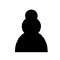
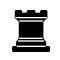
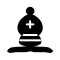
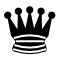
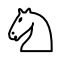
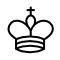
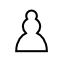
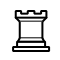
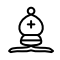
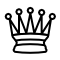
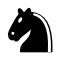
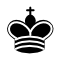

In [ ]:
# this should run a game in the environment between two random bots
# NOTE: each game starts from a randomly selected opening
result = env.run(["random", "random"])
env.render(mode="ipython", width=1000, height=1000)

In [ ]:
%%writefile main.py
from Chessnut import Game
import random

def chess_bot(obs):
    """
    Simple chess bot that prioritizes checkmates, then captures, queen promotions, then randomly moves.

    Args:
        obs: An object with a 'board' attribute representing the current board state as a FEN string.

    Returns:
        A string representing the chosen move in UCI notation (e.g., "e2e4")
    """
    # 0. Parse the current board state and generate legal moves using Chessnut library
    game = Game(obs.board)
    moves = list(game.get_moves())

    # 1. Check a subset of moves for checkmate
    for move in moves[:10]:
        g = Game(obs.board)
        g.apply_move(move)
        if g.status == Game.CHECKMATE:
            return move

    # 2. Check for captures
    for move in moves:
        if game.board.get_piece(Game.xy2i(move[2:4])) != ' ':
            return move

    # 3. Check for queen promotions
    for move in moves:
        if "q" in move.lower():
            return move

    # 4. Random move if no checkmates or captures
    return random.choice(moves)


Writing main.py


Agent exit status/reward/time left: 
	 DONE / 1 / 9.956079
	 DONE / 0 / 10





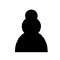
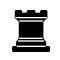
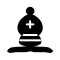
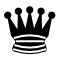
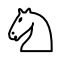
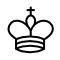
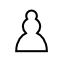
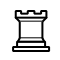
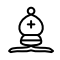
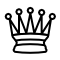
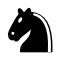
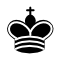

In [ ]:
result = env.run(["main.py", "random"])
print("Agent exit status/reward/time left: ")
# look at the generated replay.json and print out the agent info
for agent in result[-1]:
    print("\t", agent.status, "/", agent.reward, "/", agent.observation.remainingOverageTime)
print("\n")
# render the game
env.render(mode="ipython", width=1000, height=1000)